# Word2Bits in TensorFlow

This notebook reproduces the results of the [Word2Bits paper][1] (Lam, 2018) by applying the least necessary amount of changes to the [basic word2vec example][2] from a [TensorFlow word tutorial][3]

 [1]: https://arxiv.org/abs/1803.05651 (Word2Bits-Quantized Word Vectors)
 [2]: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
 [3]: https://www.tensorflow.org/tutorials/representation/word2vec (Vector Representations of Words)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import sys
import argparse
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tensorflow.contrib.tensorboard.plugins import projector

# Give a folder path as an argument with '--log_dir' to save
# TensorBoard summaries. Default is a log folder in current directory.
current_path = os.path.dirname(os.path.realpath(sys.argv[0]))

parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()

# Create the directory for TensorBoard variables if there is not.
if not os.path.exists(FLAGS.log_dir):
    os.makedirs(FLAGS.log_dir)

## **Step 1:** Download the data

In [2]:
url = 'http://mattmahoney.net/dc/'


# pylint: disable=redefined-outer-name
def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  local_filename = os.path.join('.', filename)
  if not os.path.exists(local_filename):
    local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                   local_filename)
  statinfo = os.stat(local_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify ' + local_filename +
                    '. Can you get to it with a browser?')
  return local_filename


filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a list of strings.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words."""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data


vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 17005207


## **Step 2:** Build the dictionary and replace rare words with UNK token.

The Word2Bits paper [completely removes][1] rare words, whereas we replace them with a UNK token. The Word2Bits paper also keeps all words whose [frequency is larger than 5][2] and whose [frequency is larger than 1 when the hash table is rehashed][3], which amounts to a dictionary of [71,291 words][4]~~, whereas we only keep the 50,000 most frequent words in the dictionary~~.

 [1]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L398
 [2]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L225
 [3]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L248
 [4]: https://pastebin.com/PaYruqAu

In [4]:
vocabulary_size = len(set(vocabulary)) + 1


def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary


# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 0], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## **Step 3:** Function to generate a training batch for the skip-gram model.

The Word2Bits paper [computes gradients for every training sample][1], whereas we use minibatches. The Word2Bits paper also uses the CBOW model, whereas we use the Skip-gram model. The Word2Bits model also [subsamples the input data][2] with probability $1 - \frac{1\text{E}-4}{f(w_i)}$ (see [Mikolov13Distributed][3], Section 2.3), whereas we subsample the context words uniformly.

 [1]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L424
 [2]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L401
 [3]: http://papers.nips.cc/paper/5021-distributed-representations-of-words-andphrases (Distributed representations of words and phrases and their compositionality)

In [5]:
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
    print('Finished an epoch.')
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
      print('Finished an epoch.')
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels


batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
reverse_dictionary[labels[i, 0]])

3084 originated -> 5239 anarchism
3084 originated -> 12 as
12 as -> 6 a
12 as -> 3084 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


## **Step 4:** Build and train a skip-gram model.
The Word2Bits paper [uses negative sampling][1] (see [Mikolov13Distributed][2], Section 2.2), whereas we use the more general technique of [Noise Contrastive Estimation (NCE)][3]. ~~The Word2bits paper also [uses a learning rate of $0.05$ linearly decayed to $0.0001\cdot 0.05$][4].~~ The Word2bits paper also [quantizes the word embeddings][5].

 [1]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L456
 [2]: http://papers.nips.cc/paper/5021-distributed-representations-of-words-andphrases (Distributed representations of words and phrases and their compositionality)
 [3]: https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss (tf.nn.nce_loss)
 [4]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L391
 [5]: https://github.com/agnusmaximus/Word2Bits/blob/49d76b0/src/word2bits.cpp#L86

In [6]:
from math import ceil

batch_size = 128
embedding_size = 600  # Dimension of the embedding vector.
skip_window = 10  # How many words to consider left and right.
num_skips = 16  # How many times to reuse an input to generate a label.
num_sampled = 24  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

num_epochs = 10
num_steps = int(ceil(num_epochs * len(data) / (batch_size // num_skips)))

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/gpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)


    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    global_step = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)
    increment_global_step_op = tf.assign(global_step, global_step+1)
    learning_rate = tf.math.maximum(0.05 * 0.0001, tf.train.polynomial_decay(0.05, global_step, num_steps, 0.0))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
  saver = tf.train.Saver()

## **Step 5**: Begin training.

In [7]:
with tf.Session(graph=graph) as session:
  # Open a writer to write summaries.
  writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    session.run(increment_global_step_op)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
    writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
    if step == (num_steps - 1):
      writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ' (', 100 * step / num_steps, '%): ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 100000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = embeddings.eval()

  # Write corresponding labels for the embeddings.
  with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
    for i in xrange(vocabulary_size):
      f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
  saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
  config = projector.ProjectorConfig()
  embedding_conf = config.embeddings.add()
  embedding_conf.tensor_name = embeddings.name
  embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
  projector.visualize_embeddings(writer, config)

writer.close()

Initialized
Average loss at step  0  ( 0.0 %):  158.44578552246094
Nearest to to: deathwing, sandbank, franzoni, traven, cattle, pluriform, fitzwater, enlinea,
Nearest to from: caoz, primagenia, acres, flirt, plasmid, jxta, presburg, quantistica,
Nearest to would: qualiy, suborganellar, tongwe, appalling, shaltoot, ejecutiva, kryptonians, acetates,
Nearest to for: conley, erbaa, genedorr, simonianism, vfan, kamsky, objlog, soundalikes,
Nearest to have: uncleanliness, bernau, melrose, etiologies, blueprinted, samithi, toscanelli, hayim,
Nearest to up: shomokuroku, copps, exonuclease, liechtensteiners, humbled, pits, acknowlege, schweppes,
Nearest to four: cellararius, lockport, rampante, strathcona, sibthorp, castricum, deliberatly, bourbourg,
Nearest to called: waitor, isshukan, jebe, krxe, starokatolickiego, elorde, oxypolis, arabize,
Nearest to state: nozhay, nigde, franc, pearblossom, foix, vasilevich, pid, aerarios,
Nearest to they: faldouet, spuds, outboard, eguma, masset, glaucom

Average loss at step  166000  ( 0.78093726491 %):  27.262379608988763
Average loss at step  168000  ( 0.79034614762 %):  26.893968922615052
Average loss at step  170000  ( 0.79975503033 %):  27.126522184729577
Average loss at step  172000  ( 0.80916391304 %):  27.706539894580843
Average loss at step  174000  ( 0.818572795749 %):  25.609308030709624
Average loss at step  176000  ( 0.827981678459 %):  26.810563530683517
Average loss at step  178000  ( 0.837390561169 %):  28.34415438592434
Average loss at step  180000  ( 0.846799443879 %):  26.65910742306709
Average loss at step  182000  ( 0.856208326588 %):  27.634626539349554
Average loss at step  184000  ( 0.865617209298 %):  26.33608986067772
Average loss at step  186000  ( 0.875026092008 %):  25.539918327450753
Average loss at step  188000  ( 0.884434974718 %):  25.5511835321188
Average loss at step  190000  ( 0.893843857427 %):  25.180380561828613
Average loss at step  192000  ( 0.903252740137 %):  27.548739619374274
Average loss at

Average loss at step  350000  ( 1.64655447421 %):  17.40800279211998
Average loss at step  352000  ( 1.65596335692 %):  15.260601252198219
Average loss at step  354000  ( 1.66537223963 %):  17.115638304233553
Average loss at step  356000  ( 1.67478112234 %):  17.810428623080252
Average loss at step  358000  ( 1.68419000505 %):  16.44515318775177
Average loss at step  360000  ( 1.69359888776 %):  17.976637322962283
Average loss at step  362000  ( 1.70300777047 %):  17.297047235012055
Average loss at step  364000  ( 1.71241665318 %):  18.318692773342132
Average loss at step  366000  ( 1.72182553589 %):  15.11220432138443
Average loss at step  368000  ( 1.7312344186 %):  14.056079262912274
Average loss at step  370000  ( 1.74064330131 %):  15.379071356177331
Average loss at step  372000  ( 1.75005218402 %):  17.47123786497116
Average loss at step  374000  ( 1.75946106673 %):  17.321538520097732
Average loss at step  376000  ( 1.76886994944 %):  15.698113507151604
Average loss at step  378

Average loss at step  536000  ( 2.52158056622 %):  14.261148690700532
Average loss at step  538000  ( 2.53098944893 %):  15.734572848558425
Average loss at step  540000  ( 2.54039833164 %):  12.609189252853394
Average loss at step  542000  ( 2.54980721435 %):  11.585489942073822
Average loss at step  544000  ( 2.55921609706 %):  13.870517384767533
Average loss at step  546000  ( 2.56862497977 %):  13.754330598711967
Average loss at step  548000  ( 2.57803386247 %):  11.530377287983894
Average loss at step  550000  ( 2.58744274518 %):  12.475760643005371
Average loss at step  552000  ( 2.59685162789 %):  12.533369866013526
Average loss at step  554000  ( 2.6062605106 %):  14.33947988152504
Average loss at step  556000  ( 2.61566939331 %):  13.63838760638237
Average loss at step  558000  ( 2.62507827602 %):  12.904053284406661
Average loss at step  560000  ( 2.63448715873 %):  13.35983240544796
Average loss at step  562000  ( 2.64389604144 %):  12.423719639778136
Average loss at step  56

Average loss at step  724000  ( 3.40601554093 %):  10.144718034863471
Average loss at step  726000  ( 3.41542442364 %):  10.742324011921882
Average loss at step  728000  ( 3.42483330635 %):  10.20857047021389
Average loss at step  730000  ( 3.43424218906 %):  10.064438291490077
Average loss at step  732000  ( 3.44365107177 %):  10.630382349848746
Average loss at step  734000  ( 3.45305995448 %):  10.167616478085518
Average loss at step  736000  ( 3.46246883719 %):  10.17512045443058
Average loss at step  738000  ( 3.4718777199 %):  9.598751343250274
Average loss at step  740000  ( 3.48128660261 %):  13.682478996157647
Average loss at step  742000  ( 3.49069548532 %):  11.235288888573647
Average loss at step  744000  ( 3.50010436803 %):  10.999616738080979
Average loss at step  746000  ( 3.50951325074 %):  11.519637662887574
Average loss at step  748000  ( 3.51892213345 %):  10.513839612424373
Average loss at step  750000  ( 3.52833101616 %):  11.480836266577244
Average loss at step  75

Average loss at step  912000  ( 4.29045051565 %):  10.150705872178078
Average loss at step  914000  ( 4.29985939836 %):  8.502100249290466
Average loss at step  916000  ( 4.30926828107 %):  10.098359252929688
Average loss at step  918000  ( 4.31867716378 %):  8.711745412647725
Average loss at step  920000  ( 4.32808604649 %):  8.113348334848881
Average loss at step  922000  ( 4.3374949292 %):  8.64601167923212
Average loss at step  924000  ( 4.34690381191 %):  8.324101441562176
Average loss at step  926000  ( 4.35631269462 %):  11.280863365113735
Average loss at step  928000  ( 4.36572157733 %):  9.63711349594593
Average loss at step  930000  ( 4.37513046004 %):  11.427430925488473
Average loss at step  932000  ( 4.38453934275 %):  8.282339224338532
Average loss at step  934000  ( 4.39394822546 %):  9.5786464625597
Average loss at step  936000  ( 4.40335710817 %):  10.706477912306786
Average loss at step  938000  ( 4.41276599088 %):  10.20280819916725
Average loss at step  940000  ( 4.

Average loss at step  1102000  ( 5.18429437308 %):  9.964744395554066
Average loss at step  1104000  ( 5.19370325579 %):  8.929332692623138
Average loss at step  1106000  ( 5.2031121385 %):  8.744107395768166
Average loss at step  1108000  ( 5.21252102121 %):  8.450874930679799
Average loss at step  1110000  ( 5.22192990392 %):  8.670967532098294
Average loss at step  1112000  ( 5.23133878663 %):  8.822254763543606
Average loss at step  1114000  ( 5.24074766934 %):  9.894640745043755
Average loss at step  1116000  ( 5.25015655205 %):  9.797767520070076
Average loss at step  1118000  ( 5.25956543476 %):  8.877443396091461
Average loss at step  1120000  ( 5.26897431747 %):  9.127977888464928
Average loss at step  1122000  ( 5.27838320018 %):  9.298940949201583
Average loss at step  1124000  ( 5.28779208289 %):  19.3372478479743
Average loss at step  1126000  ( 5.2972009656 %):  18.948870474755765
Average loss at step  1128000  ( 5.30660984831 %):  9.513013892292976
Average loss at step  

Nearest to by: the, of, and, in, a, to, one, zero,
Nearest to after: the, in, of, to, one, and, a, zero,
Nearest to its: the, of, in, and, a, zero, one, to,
Average loss at step  1302000  ( 6.12518264406 %):  8.855247834444047
Average loss at step  1304000  ( 6.13459152676 %):  7.570413632690906
Average loss at step  1306000  ( 6.14400040947 %):  7.604452818870544
Average loss at step  1308000  ( 6.15340929218 %):  8.893547714591026
Average loss at step  1310000  ( 6.16281817489 %):  8.451437843292952
Average loss at step  1312000  ( 6.1722270576 %):  7.64122284424305
Average loss at step  1314000  ( 6.18163594031 %):  8.045574712395668
Average loss at step  1316000  ( 6.19104482302 %):  9.23545072710514
Average loss at step  1318000  ( 6.20045370573 %):  7.781655642390251
Average loss at step  1320000  ( 6.20986258844 %):  7.961012828648091
Average loss at step  1322000  ( 6.21927147115 %):  6.682562204420567
Average loss at step  1324000  ( 6.22868035386 %):  8.6186622890234
Average 

Nearest to up: the, zero, one, and, of, in, to, a,
Nearest to four: one, zero, the, of, and, nine, in, a,
Nearest to called: of, the, a, and, in, zero, one, to,
Nearest to state: the, of, a, in, one, and, to, zero,
Nearest to they: and, the, in, to, of, one, zero, a,
Nearest to as: the, and, of, in, to, a, one, zero,
Nearest to many: the, and, of, in, to, a, one, zero,
Nearest to five: one, zero, the, in, of, and, nine, a,
Nearest to by: the, of, and, in, a, to, one, zero,
Nearest to after: the, in, of, to, one, and, a, zero,
Nearest to its: the, of, in, and, a, zero, to, one,
Average loss at step  1502000  ( 7.06607091503 %):  7.330593570709229
Average loss at step  1504000  ( 7.07547979774 %):  7.8086778085231785
Average loss at step  1506000  ( 7.08488868045 %):  7.774635939061642
Average loss at step  1508000  ( 7.09429756316 %):  7.428991967022419
Average loss at step  1510000  ( 7.10370644587 %):  9.126140271127223
Average loss at step  1512000  ( 7.11311532858 %):  9.53332648658

Average loss at step  1696000  ( 7.97873253788 %):  8.691894244492055
Average loss at step  1698000  ( 7.98814142059 %):  8.392171703219415
Average loss at step  1700000  ( 7.9975503033 %):  7.055562497079372
Nearest to to: and, the, of, in, a, one, zero, nine,
Nearest to from: in, the, of, and, to, zero, one, a,
Nearest to would: and, the, a, to, one, of, in, zero,
Nearest to for: and, of, a, in, the, to, one, zero,
Nearest to have: and, the, of, in, a, to, one, is,
Nearest to up: zero, the, and, one, in, a, to, of,
Nearest to four: one, zero, nine, the, and, of, in, a,
Nearest to called: the, of, a, and, in, one, zero, nine,
Nearest to state: the, of, in, one, a, and, to, zero,
Nearest to they: and, the, to, in, of, a, one, zero,
Nearest to as: and, the, of, in, to, a, one, zero,
Nearest to many: and, the, in, of, to, a, one, zero,
Nearest to five: one, zero, nine, in, the, two, and, of,
Nearest to by: the, of, and, in, a, to, one, zero,
Nearest to after: the, in, to, one, of, and, a

Average loss at step  1882000  ( 8.85375862989 %):  8.385748326301576
Average loss at step  1884000  ( 8.8631675126 %):  7.089693834066391
Average loss at step  1886000  ( 8.87257639531 %):  8.870399468064308
Average loss at step  1888000  ( 8.88198527802 %):  7.835593160331249
Average loss at step  1890000  ( 8.89139416073 %):  8.021106639146804
Average loss at step  1892000  ( 8.90080304343 %):  6.593195373535156
Average loss at step  1894000  ( 8.91021192614 %):  7.043069262027741
Average loss at step  1896000  ( 8.91962080885 %):  7.2403600729703905
Average loss at step  1898000  ( 8.92902969156 %):  6.8678693904280665
Average loss at step  1900000  ( 8.93843857427 %):  6.190006768882275
Nearest to to: and, the, in, of, a, one, zero, nine,
Nearest to from: the, in, and, of, to, one, zero, a,
Nearest to would: and, the, to, a, one, in, of, zero,
Nearest to for: and, in, a, the, of, to, one, zero,
Nearest to have: and, the, of, in, a, to, one, is,
Nearest to up: zero, the, one, and, 

Average loss at step  2068000  ( 9.72878472189 %):  7.992047979235649
Average loss at step  2070000  ( 9.7381936046 %):  7.385782218635082
Average loss at step  2072000  ( 9.74760248731 %):  7.914819710969925
Average loss at step  2074000  ( 9.75701137002 %):  5.297923342168331
Average loss at step  2076000  ( 9.76642025273 %):  7.317091475486755
Average loss at step  2078000  ( 9.77582913544 %):  6.961197910070419
Average loss at step  2080000  ( 9.78523801815 %):  6.893438199639321
Average loss at step  2082000  ( 9.79464690086 %):  7.4928384190797805
Average loss at step  2084000  ( 9.80405578357 %):  7.9880260099172595
Average loss at step  2086000  ( 9.81346466628 %):  8.30613607764244
Average loss at step  2088000  ( 9.82287354899 %):  9.09436306977272
Average loss at step  2090000  ( 9.8322824317 %):  7.861077969193459
Average loss at step  2092000  ( 9.84169131441 %):  8.289544081568717
Average loss at step  2094000  ( 9.85110019712 %):  7.744273918628693
Average loss at step  

Average loss at step  2254000  ( 10.6038108139 %):  6.064774651288986
Average loss at step  2256000  ( 10.6132196966 %):  7.04096300971508
Average loss at step  2258000  ( 10.6226285793 %):  7.734077015697956
Average loss at step  2260000  ( 10.632037462 %):  7.086824172973633
Average loss at step  2262000  ( 10.6414463447 %):  7.451905153155327
Average loss at step  2264000  ( 10.6508552275 %):  8.057423842906951
Average loss at step  2266000  ( 10.6602641102 %):  7.100168589770794
Average loss at step  2268000  ( 10.6696729929 %):  6.4954181469678876
Average loss at step  2270000  ( 10.6790818756 %):  7.069418611228466
Average loss at step  2272000  ( 10.6884907583 %):  6.026855369329453
Average loss at step  2274000  ( 10.697899641 %):  6.988567870438099
Average loss at step  2276000  ( 10.7073085237 %):  6.89705082988739
Average loss at step  2278000  ( 10.7167174064 %):  7.5884153715372085
Average loss at step  2280000  ( 10.7261262891 %):  6.762875771999359
Average loss at step  

Average loss at step  2442000  ( 11.4882457886 %):  7.582029736161232
Average loss at step  2444000  ( 11.4976546713 %):  6.521167588710785
Average loss at step  2446000  ( 11.507063554 %):  7.199345835089684
Average loss at step  2448000  ( 11.5164724367 %):  6.4004844829440115
Average loss at step  2450000  ( 11.5258813195 %):  5.8154106674194335
Average loss at step  2452000  ( 11.5352902022 %):  7.70229095685482
Average loss at step  2454000  ( 11.5446990849 %):  5.2229134349823
Average loss at step  2456000  ( 11.5541079676 %):  6.142772624850273
Average loss at step  2458000  ( 11.5635168503 %):  6.822463802099228
Average loss at step  2460000  ( 11.572925733 %):  5.889689770817757
Average loss at step  2462000  ( 11.5823346157 %):  6.3941937911510465
Average loss at step  2464000  ( 11.5917434984 %):  6.35319000685215
Average loss at step  2466000  ( 11.6011523811 %):  6.124175451219082
Average loss at step  2468000  ( 11.6105612638 %):  5.952483299136162
Average loss at step  2

Average loss at step  2628000  ( 12.3632718806 %):  6.267519286155701
Average loss at step  2630000  ( 12.3726807633 %):  5.346362054884434
Average loss at step  2632000  ( 12.382089646 %):  6.038529398679733
Average loss at step  2634000  ( 12.3914985288 %):  5.855071350634098
Average loss at step  2636000  ( 12.4009074115 %):  5.945486045777797
Average loss at step  2638000  ( 12.4103162942 %):  7.049606801986695
Average loss at step  2640000  ( 12.4197251769 %):  6.009511042773724
Average loss at step  2642000  ( 12.4291340596 %):  5.644378744721413
Average loss at step  2644000  ( 12.4385429423 %):  6.4046806329488755
Average loss at step  2646000  ( 12.447951825 %):  5.9050783089995385
Average loss at step  2648000  ( 12.4573607077 %):  6.280731857955455
Average loss at step  2650000  ( 12.4667695904 %):  6.128591428875923
Average loss at step  2652000  ( 12.4761784731 %):  6.236732230007648
Average loss at step  2654000  ( 12.4855873559 %):  5.405935684382915
Average loss at step

Average loss at step  2814000  ( 13.2382979726 %):  6.535858850598335
Average loss at step  2816000  ( 13.2477068553 %):  5.7015087615251545
Average loss at step  2818000  ( 13.2571157381 %):  6.531954571187496
Average loss at step  2820000  ( 13.2665246208 %):  6.677268423438072
Average loss at step  2822000  ( 13.2759335035 %):  6.650452115297318
Average loss at step  2824000  ( 13.2853423862 %):  6.436730301380157
Average loss at step  2826000  ( 13.2947512689 %):  5.89543894648552
Average loss at step  2828000  ( 13.3041601516 %):  5.968089480996132
Average loss at step  2830000  ( 13.3135690343 %):  7.2859198867082595
Average loss at step  2832000  ( 13.322977917 %):  6.068922969698906
Average loss at step  2834000  ( 13.3323867997 %):  6.246990375995636
Average loss at step  2836000  ( 13.3417956824 %):  7.275089386224747
Average loss at step  2838000  ( 13.3512045652 %):  5.845262856245041
Average loss at step  2840000  ( 13.3606134479 %):  6.751273142099381
Average loss at step

Average loss at step  3002000  ( 14.1227329474 %):  6.032284737348556
Average loss at step  3004000  ( 14.1321418301 %):  6.615766251087189
Average loss at step  3006000  ( 14.1415507128 %):  5.774563328623771
Average loss at step  3008000  ( 14.1509595955 %):  6.061577815294266
Average loss at step  3010000  ( 14.1603684782 %):  5.922346147596836
Average loss at step  3012000  ( 14.1697773609 %):  8.11619803249836
Average loss at step  3014000  ( 14.1791862436 %):  6.740940843224525
Average loss at step  3016000  ( 14.1885951263 %):  5.669796324133873
Average loss at step  3018000  ( 14.198004009 %):  6.274294015824795
Average loss at step  3020000  ( 14.2074128917 %):  6.2742898879051205
Average loss at step  3022000  ( 14.2168217745 %):  5.529948011517525
Average loss at step  3024000  ( 14.2262306572 %):  5.592784870743752
Average loss at step  3026000  ( 14.2356395399 %):  6.104828179359436
Average loss at step  3028000  ( 14.2450484226 %):  5.66444502466917
Average loss at step  

Nearest to after: in, the, to, one, of, and, a, nine,
Nearest to its: the, of, a, in, and, to, is, zero,
Average loss at step  3202000  ( 15.0636212183 %):  5.529533283770085
Average loss at step  3204000  ( 15.073030101 %):  6.162456523299217
Average loss at step  3206000  ( 15.0824389837 %):  4.961098599672318
Average loss at step  3208000  ( 15.0918478665 %):  5.953467724680901
Average loss at step  3210000  ( 15.1012567492 %):  6.378102941274643
Average loss at step  3212000  ( 15.1106656319 %):  6.311500219523906
Average loss at step  3214000  ( 15.1200745146 %):  6.942752720355988
Average loss at step  3216000  ( 15.1294833973 %):  5.990888496518135
Average loss at step  3218000  ( 15.13889228 %):  6.087976111531257
Average loss at step  3220000  ( 15.1483011627 %):  6.1772224711179735
Average loss at step  3222000  ( 15.1577100454 %):  6.019366932630539
Average loss at step  3224000  ( 15.1671189281 %):  6.116007169306278
Average loss at step  3226000  ( 15.1765278108 %):  6.141

Nearest to up: the, and, a, one, to, in, zero, two,
Nearest to four: one, zero, two, nine, eight, three, and, the,
Nearest to called: a, the, of, and, in, as, is, to,
Nearest to state: the, of, one, a, in, and, to, is,
Nearest to they: to, and, the, in, of, a, one, as,
Nearest to as: and, in, of, the, a, to, one, is,
Nearest to many: and, the, to, in, of, as, a, one,
Nearest to five: one, zero, two, nine, eight, the, three, and,
Nearest to by: of, the, and, in, a, to, one, two,
Nearest to after: in, the, to, one, of, and, a, nine,
Nearest to its: the, of, a, in, and, to, is, zero,
Average loss at step  3402000  ( 16.0045094893 %):  5.834612142086029
Average loss at step  3404000  ( 16.013918372 %):  6.075358046352863
Average loss at step  3406000  ( 16.0233272547 %):  6.530333367943764
Average loss at step  3408000  ( 16.0327361374 %):  6.542681557536125
Average loss at step  3410000  ( 16.0421450201 %):  6.106907012581825
Average loss at step  3412000  ( 16.0515539029 %):  6.230406361

Average loss at step  3596000  ( 16.9171711122 %):  5.996213628232479
Average loss at step  3598000  ( 16.9265799949 %):  6.243442523002624
Average loss at step  3600000  ( 16.9359888776 %):  5.891221981108188
Nearest to to: and, the, in, of, a, one, as, two,
Nearest to from: in, and, the, of, to, one, a, zero,
Nearest to would: to, and, the, a, one, in, of, zero,
Nearest to for: and, in, a, to, of, the, one, zero,
Nearest to have: and, of, the, in, to, a, is, two,
Nearest to up: the, a, one, and, in, to, zero, two,
Nearest to four: one, zero, two, nine, three, eight, five, the,
Nearest to called: a, the, of, and, in, is, as, to,
Nearest to state: the, of, one, in, a, and, to, is,
Nearest to they: to, and, the, in, of, a, one, that,
Nearest to as: and, in, of, the, a, to, one, is,
Nearest to many: and, the, to, in, of, as, a, for,
Nearest to five: one, zero, two, nine, three, eight, the, in,
Nearest to by: the, of, and, in, a, one, to, two,
Nearest to after: in, the, to, one, and, of, 

Average loss at step  3782000  ( 17.7921972042 %):  5.780477369427681
Average loss at step  3784000  ( 17.8016060869 %):  5.863368245124817
Average loss at step  3786000  ( 17.8110149696 %):  5.716488005161286
Average loss at step  3788000  ( 17.8204238523 %):  5.406171733617783
Average loss at step  3790000  ( 17.829832735 %):  5.831101971149445
Average loss at step  3792000  ( 17.8392416177 %):  5.580507694542408
Average loss at step  3794000  ( 17.8486505004 %):  5.389367255926132
Average loss at step  3796000  ( 17.8580593831 %):  5.621808643341065
Average loss at step  3798000  ( 17.8674682658 %):  5.264172948539257
Average loss at step  3800000  ( 17.8768771485 %):  6.654259245097637
Nearest to to: and, the, in, of, a, one, as, for,
Nearest to from: in, and, the, of, to, a, one, zero,
Nearest to would: to, and, the, a, in, of, one, with,
Nearest to for: and, in, a, to, of, the, as, one,
Nearest to have: and, of, the, in, a, to, is, two,
Nearest to up: and, the, a, in, to, one, ze

Average loss at step  3968000  ( 18.6672232962 %):  5.958666373789311
Average loss at step  3970000  ( 18.6766321789 %):  6.649876554608345
Average loss at step  3972000  ( 18.6860410616 %):  4.811745667397976
Average loss at step  3974000  ( 18.6954499443 %):  7.999185953974724
Average loss at step  3976000  ( 18.704858827 %):  5.296604628324508
Average loss at step  3978000  ( 18.7142677097 %):  6.50601339495182
Average loss at step  3980000  ( 18.7236765924 %):  5.906117858409882
Average loss at step  3982000  ( 18.7330854751 %):  6.1950584567785265
Average loss at step  3984000  ( 18.7424943578 %):  6.6708925178050995
Average loss at step  3986000  ( 18.7519032406 %):  5.250482335329056
Average loss at step  3988000  ( 18.7613121233 %):  6.344450796723366
Average loss at step  3990000  ( 18.770721006 %):  6.80005483931303
Average loss at step  3992000  ( 18.7801298887 %):  6.121856778740883
Average loss at step  3994000  ( 18.7895387714 %):  5.309681845068932
Average loss at step  

Average loss at step  4154000  ( 19.5422493882 %):  5.444257182836533
Average loss at step  4156000  ( 19.5516582709 %):  6.371636608600617
Average loss at step  4158000  ( 19.5610671536 %):  5.310354155659676
Average loss at step  4160000  ( 19.5704760363 %):  5.413292098402977
Average loss at step  4162000  ( 19.579884919 %):  5.493409806370735
Average loss at step  4164000  ( 19.5892938017 %):  6.063502041101455
Average loss at step  4166000  ( 19.5987026844 %):  5.529699608564377
Average loss at step  4168000  ( 19.6081115671 %):  5.3278420232534405
Average loss at step  4170000  ( 19.6175204499 %):  5.857915094137192
Average loss at step  4172000  ( 19.6269293326 %):  6.4908850091695784
Average loss at step  4174000  ( 19.6363382153 %):  5.960053190588951
Average loss at step  4176000  ( 19.645747098 %):  6.051785273849964
Average loss at step  4178000  ( 19.6551559807 %):  5.805050968527794
Average loss at step  4180000  ( 19.6645648634 %):  5.398001717329025
Average loss at step

Average loss at step  4340000  ( 20.4172754802 %):  5.283976930081844
Average loss at step  4342000  ( 20.4266843629 %):  5.704905222058296
Average loss at step  4344000  ( 20.4360932456 %):  5.862730913281441
Average loss at step  4346000  ( 20.4455021283 %):  5.355292170286178
Average loss at step  4348000  ( 20.454911011 %):  6.300465186715126
Average loss at step  4350000  ( 20.4643198937 %):  6.40416233253479
Average loss at step  4352000  ( 20.4737287764 %):  5.860255873560906
Average loss at step  4354000  ( 20.4831376592 %):  5.69174452894926
Average loss at step  4356000  ( 20.4925465419 %):  6.308432312846183
Average loss at step  4358000  ( 20.5019554246 %):  6.477659419059753
Average loss at step  4360000  ( 20.5113643073 %):  5.722836700022221
Average loss at step  4362000  ( 20.52077319 %):  5.762546232938766
Average loss at step  4364000  ( 20.5301820727 %):  6.366328461647034
Average loss at step  4366000  ( 20.5395909554 %):  4.7540417689085
Average loss at step  43680

Average loss at step  4528000  ( 21.3017104549 %):  6.458849475741387
Average loss at step  4530000  ( 21.3111193376 %):  5.618112656593323
Average loss at step  4532000  ( 21.3205282203 %):  6.010181086421013
Average loss at step  4534000  ( 21.329937103 %):  5.231074500083923
Average loss at step  4536000  ( 21.3393459857 %):  5.46920324075222
Average loss at step  4538000  ( 21.3487548684 %):  5.066609919548035
Average loss at step  4540000  ( 21.3581637512 %):  5.38686717736721
Average loss at step  4542000  ( 21.3675726339 %):  5.976432083368302
Average loss at step  4544000  ( 21.3769815166 %):  5.717805016636849
Average loss at step  4546000  ( 21.3863903993 %):  6.5181964348554615
Average loss at step  4548000  ( 21.395799282 %):  5.848168484449387
Average loss at step  4550000  ( 21.4052081647 %):  5.381026724815369
Average loss at step  4552000  ( 21.4146170474 %):  5.422920355796814
Average loss at step  4554000  ( 21.4240259301 %):  5.5434376000761985
Average loss at step  

Average loss at step  4714000  ( 22.1767365469 %):  6.046079877853393
Average loss at step  4716000  ( 22.1861454296 %):  5.301273750066757
Average loss at step  4718000  ( 22.1955543123 %):  5.153675398349762
Average loss at step  4720000  ( 22.204963195 %):  5.486898998379707
Average loss at step  4722000  ( 22.2143720777 %):  5.642981401979923
Average loss at step  4724000  ( 22.2237809605 %):  5.852228898763657
Average loss at step  4726000  ( 22.2331898432 %):  5.037586832284927
Average loss at step  4728000  ( 22.2425987259 %):  5.154175663948059
Average loss at step  4730000  ( 22.2520076086 %):  4.553416400194168
Average loss at step  4732000  ( 22.2614164913 %):  4.43474362206459
Average loss at step  4734000  ( 22.270825374 %):  5.274028533577919
Average loss at step  4736000  ( 22.2802342567 %):  6.149958534121513
Average loss at step  4738000  ( 22.2896431394 %):  4.828332073807716
Average loss at step  4740000  ( 22.2990520221 %):  4.908690575122833
Average loss at step  4

Average loss at step  4902000  ( 23.0611715216 %):  4.915302722096444
Average loss at step  4904000  ( 23.0705804043 %):  5.5390532295703885
Average loss at step  4906000  ( 23.079989287 %):  8.14696947145462
Average loss at step  4908000  ( 23.0893981698 %):  5.410904249966144
Average loss at step  4910000  ( 23.0988070525 %):  5.154264695823192
Average loss at step  4912000  ( 23.1082159352 %):  5.385432778954506
Average loss at step  4914000  ( 23.1176248179 %):  5.460981244921684
Average loss at step  4916000  ( 23.1270337006 %):  5.196101234555244
Average loss at step  4918000  ( 23.1364425833 %):  5.418352988004685
Average loss at step  4920000  ( 23.145851466 %):  5.77442420065403
Average loss at step  4922000  ( 23.1552603487 %):  5.58259763777256
Average loss at step  4924000  ( 23.1646692314 %):  4.996483247280121
Average loss at step  4926000  ( 23.1740781141 %):  6.098910786986351
Average loss at step  4928000  ( 23.1834869969 %):  5.066662040233612
Average loss at step  49

Nearest to after: in, the, to, and, one, of, a, two,
Nearest to its: the, of, a, in, and, is, to, s,
Average loss at step  5102000  ( 24.0020597926 %):  5.553399699211121
Average loss at step  5104000  ( 24.0114686753 %):  5.329670399129391
Average loss at step  5106000  ( 24.020877558 %):  5.538175355911255
Average loss at step  5108000  ( 24.0302864407 %):  5.339319589734077
Average loss at step  5110000  ( 24.0396953234 %):  5.485261351168155
Average loss at step  5112000  ( 24.0491042062 %):  5.75964855325222
Average loss at step  5114000  ( 24.0585130889 %):  5.324675115346909
Average loss at step  5116000  ( 24.0679219716 %):  5.611505720674992
Average loss at step  5118000  ( 24.0773308543 %):  5.084958033621311
Average loss at step  5120000  ( 24.086739737 %):  5.544766095161438
Average loss at step  5122000  ( 24.0961486197 %):  5.334667407274246
Average loss at step  5124000  ( 24.1055575024 %):  5.790527432858944
Average loss at step  5126000  ( 24.1149663851 %):  5.30353394

Nearest to after: in, to, the, and, one, of, a, nine,
Nearest to its: the, of, a, in, and, is, to, s,
Average loss at step  5302000  ( 24.9429480636 %):  4.899847771048546
Average loss at step  5304000  ( 24.9523569463 %):  5.015693080127239
Average loss at step  5306000  ( 24.961765829 %):  5.956870081663132
Average loss at step  5308000  ( 24.9711747117 %):  5.843453958034515
Average loss at step  5310000  ( 24.9805835944 %):  6.637927427768707
Average loss at step  5312000  ( 24.9899924771 %):  5.482665264725685
Average loss at step  5314000  ( 24.9994013598 %):  4.954550351858139
Average loss at step  5316000  ( 25.0088102425 %):  5.125074666023254
Average loss at step  5318000  ( 25.0182191253 %):  6.032776497244835
Average loss at step  5320000  ( 25.027628008 %):  5.0860041826963425
Average loss at step  5322000  ( 25.0370368907 %):  4.7331841403245924
Average loss at step  5324000  ( 25.0464457734 %):  5.550367079734802
Average loss at step  5326000  ( 25.0558546561 %):  5.0631

Nearest to up: the, and, a, to, in, one, two, zero,
Nearest to four: one, two, three, five, zero, eight, nine, six,
Nearest to called: a, of, the, and, is, as, in, to,
Nearest to state: the, of, one, in, a, and, to, by,
Nearest to they: to, and, the, in, that, of, a, as,
Nearest to as: and, in, the, of, a, to, is, one,
Nearest to many: and, the, to, as, in, of, for, a,
Nearest to five: one, two, zero, three, four, six, eight, seven,
Nearest to by: of, the, and, in, a, to, one, as,
Nearest to after: in, to, the, one, and, of, a, nine,
Nearest to its: the, of, a, in, and, is, to, s,
Average loss at step  5502000  ( 25.8838363346 %):  4.8046586924791335
Average loss at step  5504000  ( 25.8932452173 %):  5.316743404984474
Average loss at step  5506000  ( 25.9026541 %):  6.71653766131401
Average loss at step  5508000  ( 25.9120629827 %):  5.743064798653125
Average loss at step  5510000  ( 25.9214718654 %):  5.919268110573292
Average loss at step  5512000  ( 25.9308807481 %):  4.83077765631

Average loss at step  5696000  ( 26.7964979574 %):  5.281654321312905
Average loss at step  5698000  ( 26.8059068401 %):  5.3176093262434
Average loss at step  5700000  ( 26.8153157228 %):  5.499094399809837
Nearest to to: and, the, in, of, a, that, as, one,
Nearest to from: in, and, the, of, to, one, a, two,
Nearest to would: to, the, and, a, with, in, one, of,
Nearest to for: and, in, a, of, to, the, as, two,
Nearest to have: and, the, of, in, are, to, a, that,
Nearest to up: the, and, a, to, in, one, two, zero,
Nearest to four: one, two, three, five, zero, eight, six, nine,
Nearest to called: a, the, of, and, is, as, in, to,
Nearest to state: the, of, one, in, and, a, to, by,
Nearest to they: to, and, the, in, that, of, as, a,
Nearest to as: and, in, the, of, a, to, one, for,
Nearest to many: and, the, to, as, in, of, for, with,
Nearest to five: one, two, zero, three, four, six, eight, seven,
Nearest to by: the, of, and, in, a, one, to, as,
Nearest to after: in, to, the, one, and, o

Average loss at step  5882000  ( 27.6715240494 %):  5.083009190201759
Average loss at step  5884000  ( 27.6809329321 %):  5.389153628587723
Average loss at step  5886000  ( 27.6903418148 %):  5.894475094527007
Average loss at step  5888000  ( 27.6997506975 %):  5.07495950114727
Average loss at step  5890000  ( 27.7091595802 %):  5.112315890789032
Average loss at step  5892000  ( 27.718568463 %):  5.0289635572433475
Average loss at step  5894000  ( 27.7279773457 %):  5.698128533780575
Average loss at step  5896000  ( 27.7373862284 %):  4.927829788446426
Average loss at step  5898000  ( 27.7467951111 %):  5.1627301318645475
Average loss at step  5900000  ( 27.7562039938 %):  4.880707456469536
Nearest to to: and, the, in, of, a, that, as, for,
Nearest to from: in, and, the, of, to, a, by, as,
Nearest to would: to, and, the, a, with, in, it, of,
Nearest to for: and, in, a, the, to, of, as, is,
Nearest to have: and, the, of, in, are, a, to, that,
Nearest to up: the, and, a, in, to, was, two

Average loss at step  6068000  ( 28.5465501414 %):  5.3094609452486035
Average loss at step  6070000  ( 28.5559590241 %):  5.447808023571968
Average loss at step  6072000  ( 28.5653679068 %):  7.798416102588177
Average loss at step  6074000  ( 28.5747767895 %):  5.066836372971535
Average loss at step  6076000  ( 28.5841856723 %):  5.797152690649033
Average loss at step  6078000  ( 28.593594555 %):  5.25870791053772
Average loss at step  6080000  ( 28.6030034377 %):  5.200872885584832
Average loss at step  6082000  ( 28.6124123204 %):  5.567996534943581
Average loss at step  6084000  ( 28.6218212031 %):  5.220546684205532
Average loss at step  6086000  ( 28.6312300858 %):  5.597847034573555
Average loss at step  6088000  ( 28.6406389685 %):  5.519785468220711
Average loss at step  6090000  ( 28.6500478512 %):  5.531911295592785
Average loss at step  6092000  ( 28.6594567339 %):  7.826674580574036
Average loss at step  6094000  ( 28.6688656166 %):  4.807935432970524
Average loss at step 

Average loss at step  6254000  ( 29.4215762334 %):  4.8214006951451305
Average loss at step  6256000  ( 29.4309851161 %):  4.910965609192848
Average loss at step  6258000  ( 29.4403939988 %):  5.19727729344368
Average loss at step  6260000  ( 29.4498028816 %):  4.815592311382294
Average loss at step  6262000  ( 29.4592117643 %):  4.724248811244965
Average loss at step  6264000  ( 29.468620647 %):  5.674996578931808
Average loss at step  6266000  ( 29.4780295297 %):  5.68543544280529
Average loss at step  6268000  ( 29.4874384124 %):  5.033279948353767
Average loss at step  6270000  ( 29.4968472951 %):  4.91858268404007
Average loss at step  6272000  ( 29.5062561778 %):  5.438173197865487
Average loss at step  6274000  ( 29.5156650605 %):  5.919023971676826
Average loss at step  6276000  ( 29.5250739432 %):  5.5549629987478255
Average loss at step  6278000  ( 29.5344828259 %):  5.2931711667776105
Average loss at step  6280000  ( 29.5438917087 %):  5.098452311098575
Average loss at step 

Average loss at step  6440000  ( 30.2966023254 %):  4.8963914355039595
Average loss at step  6442000  ( 30.3060112081 %):  6.134841533899308
Average loss at step  6444000  ( 30.3154200909 %):  4.945823011517525
Average loss at step  6446000  ( 30.3248289736 %):  5.458625720083713
Average loss at step  6448000  ( 30.3342378563 %):  5.100296245455742
Average loss at step  6450000  ( 30.343646739 %):  5.10843696141243
Average loss at step  6452000  ( 30.3530556217 %):  5.7106112337112425
Average loss at step  6454000  ( 30.3624645044 %):  4.642434420228004
Average loss at step  6456000  ( 30.3718733871 %):  4.854641347587108
Average loss at step  6458000  ( 30.3812822698 %):  5.163681011199952
Average loss at step  6460000  ( 30.3906911525 %):  5.34396774482727
Average loss at step  6462000  ( 30.4001000352 %):  5.210098382115364
Average loss at step  6464000  ( 30.409508918 %):  4.832941737890244
Average loss at step  6466000  ( 30.4189178007 %):  4.830277912557125
Average loss at step  

Average loss at step  6626000  ( 31.1716284174 %):  5.385903039216995
Average loss at step  6628000  ( 31.1810373002 %):  4.41661748957634
Average loss at step  6630000  ( 31.1904461829 %):  5.255787410736084
Average loss at step  6632000  ( 31.1998550656 %):  4.647407699584961
Average loss at step  6634000  ( 31.2092639483 %):  5.358257842540741
Average loss at step  6636000  ( 31.218672831 %):  5.5023024115562436
Average loss at step  6638000  ( 31.2280817137 %):  5.287875864923
Average loss at step  6640000  ( 31.2374905964 %):  5.2214476721286776
Average loss at step  6642000  ( 31.2468994791 %):  4.813096046686172
Average loss at step  6644000  ( 31.2563083618 %):  4.848689946651459
Average loss at step  6646000  ( 31.2657172445 %):  4.481857058882714
Average loss at step  6648000  ( 31.2751261272 %):  4.855100134015084
Average loss at step  6650000  ( 31.28453501 %):  4.875737605929375
Average loss at step  6652000  ( 31.2939438927 %):  4.909890236258507
Average loss at step  665

Average loss at step  6812000  ( 32.0466545094 %):  4.945961439251899
Average loss at step  6814000  ( 32.0560633922 %):  5.55112244606018
Average loss at step  6816000  ( 32.0654722749 %):  4.866635771095753
Average loss at step  6818000  ( 32.0748811576 %):  5.523444437265396
Average loss at step  6820000  ( 32.0842900403 %):  4.868094696938991
Average loss at step  6822000  ( 32.093698923 %):  4.584910902261734
Average loss at step  6824000  ( 32.1031078057 %):  5.292768605589867
Average loss at step  6826000  ( 32.1125166884 %):  5.349612954616546
Average loss at step  6828000  ( 32.1219255711 %):  5.142341738581657
Average loss at step  6830000  ( 32.1313344538 %):  5.057750310063362
Average loss at step  6832000  ( 32.1407433365 %):  4.955906831860542
Average loss at step  6834000  ( 32.1501522193 %):  4.758778302907944
Average loss at step  6836000  ( 32.159561102 %):  5.112990935325622
Average loss at step  6838000  ( 32.1689699847 %):  5.101848583459854
Average loss at step  6

Nearest to by: and, the, of, in, a, to, one, as,
Nearest to after: in, the, to, one, of, and, a, was,
Nearest to its: the, of, a, in, and, s, is, to,
Average loss at step  7002000  ( 32.9404983669 %):  5.342734451651573
Average loss at step  7004000  ( 32.9499072496 %):  4.831882978320122
Average loss at step  7006000  ( 32.9593161323 %):  7.444648510873318
Average loss at step  7008000  ( 32.968725015 %):  4.872214682340622
Average loss at step  7010000  ( 32.9781338977 %):  5.335613728165627
Average loss at step  7012000  ( 32.9875427804 %):  5.039516765654087
Average loss at step  7014000  ( 32.9969516631 %):  4.609355287492275
Average loss at step  7016000  ( 33.0063605458 %):  5.30181971013546
Average loss at step  7018000  ( 33.0157694286 %):  4.614744787931442
Average loss at step  7020000  ( 33.0251783113 %):  5.25129722392559
Average loss at step  7022000  ( 33.034587194 %):  5.237416558265686
Average loss at step  7024000  ( 33.0439960767 %):  4.742949998378753
Average loss a

Nearest to up: the, and, a, to, in, two, was, one,
Nearest to four: three, five, one, two, six, eight, zero, seven,
Nearest to called: a, of, the, is, as, and, in, by,
Nearest to state: the, of, in, to, a, one, and, by,
Nearest to they: to, and, the, that, in, as, are, from,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, in, for, of, with,
Nearest to five: one, two, three, four, zero, six, eight, seven,
Nearest to by: and, the, of, in, a, to, as, one,
Nearest to after: in, the, to, and, of, one, a, was,
Nearest to its: the, of, a, in, and, is, s, to,
Average loss at step  7202000  ( 33.8813866379 %):  5.39931204855442
Average loss at step  7204000  ( 33.8907955206 %):  4.786654926240444
Average loss at step  7206000  ( 33.9002044033 %):  5.0129728447198865
Average loss at step  7208000  ( 33.909613286 %):  5.089963255763054
Average loss at step  7210000  ( 33.9190221687 %):  4.774317700862884
Average loss at step  7212000  ( 33.9284310514 %):  4.9

Average loss at step  7396000  ( 34.7940482607 %):  5.107050725936889
Average loss at step  7398000  ( 34.8034571434 %):  4.845032225251198
Average loss at step  7400000  ( 34.8128660261 %):  5.360325391888619
Nearest to to: and, the, in, of, a, that, for, as,
Nearest to from: in, and, the, of, to, by, a, one,
Nearest to would: to, and, the, with, a, it, of, in,
Nearest to for: and, in, of, a, the, to, as, two,
Nearest to have: and, the, of, are, in, that, to, for,
Nearest to up: the, and, a, in, to, two, one, was,
Nearest to four: three, five, one, two, six, eight, zero, nine,
Nearest to called: a, of, the, is, as, and, in, by,
Nearest to state: the, of, in, to, one, a, and, by,
Nearest to they: to, and, the, that, in, as, are, of,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, in, for, of, with,
Nearest to five: one, two, three, four, zero, six, eight, seven,
Nearest to by: the, and, of, in, a, to, one, as,
Nearest to after: in, the, to, and, on

Average loss at step  7582000  ( 35.6690743527 %):  4.518239090144634
Average loss at step  7584000  ( 35.6784832354 %):  4.797883894145489
Average loss at step  7586000  ( 35.6878921181 %):  5.090490982234478
Average loss at step  7588000  ( 35.6973010008 %):  4.654046909809113
Average loss at step  7590000  ( 35.7067098835 %):  4.977080383181572
Average loss at step  7592000  ( 35.7161187663 %):  5.013750713646412
Average loss at step  7594000  ( 35.725527649 %):  4.85489764714241
Average loss at step  7596000  ( 35.7349365317 %):  5.846014769077301
Average loss at step  7598000  ( 35.7443454144 %):  4.871680976629257
Average loss at step  7600000  ( 35.7537542971 %):  4.590464836716652
Nearest to to: and, the, in, of, a, that, for, as,
Nearest to from: in, and, the, of, to, a, by, two,
Nearest to would: to, and, the, with, a, it, of, in,
Nearest to for: and, in, of, a, the, to, as, two,
Nearest to have: and, are, the, of, in, that, to, for,
Nearest to up: the, and, a, to, in, one, t

Average loss at step  7768000  ( 36.5441004447 %):  5.850348499178886
Average loss at step  7770000  ( 36.5535093274 %):  5.286748732328415
Average loss at step  7772000  ( 36.5629182101 %):  5.030028165221214
Average loss at step  7774000  ( 36.5723270928 %):  4.8441591479778285
Average loss at step  7776000  ( 36.5817359756 %):  5.093515493750572
Average loss at step  7778000  ( 36.5911448583 %):  4.745052493810654
Average loss at step  7780000  ( 36.600553741 %):  4.440627445578575
Average loss at step  7782000  ( 36.6099626237 %):  5.344182506680489
Average loss at step  7784000  ( 36.6193715064 %):  5.08261762368679
Average loss at step  7786000  ( 36.6287803891 %):  4.76918702852726
Average loss at step  7788000  ( 36.6381892718 %):  5.0126113697886465
Average loss at step  7790000  ( 36.6475981545 %):  4.8040046486854555
Average loss at step  7792000  ( 36.6570070372 %):  4.900121531605721
Average loss at step  7794000  ( 36.6664159199 %):  5.104022564172745
Average loss at step

Average loss at step  7954000  ( 37.4191265367 %):  4.688719041228294
Average loss at step  7956000  ( 37.4285354194 %):  4.87186293554306
Average loss at step  7958000  ( 37.4379443021 %):  4.593973054647446
Average loss at step  7960000  ( 37.4473531849 %):  4.7894675884246825
Average loss at step  7962000  ( 37.4567620676 %):  4.473263953328132
Average loss at step  7964000  ( 37.4661709503 %):  4.73189027762413
Average loss at step  7966000  ( 37.475579833 %):  5.004282924056053
Average loss at step  7968000  ( 37.4849887157 %):  5.207263038754463
Average loss at step  7970000  ( 37.4943975984 %):  5.001237389028073
Average loss at step  7972000  ( 37.5038064811 %):  5.059549669981003
Average loss at step  7974000  ( 37.5132153638 %):  4.952147029995919
Average loss at step  7976000  ( 37.5226242465 %):  4.97124128985405
Average loss at step  7978000  ( 37.5320331292 %):  4.917472223341465
Average loss at step  7980000  ( 37.541442012 %):  4.887396995544433
Average loss at step  79

Average loss at step  8140000  ( 38.2941526287 %):  5.046754685342312
Average loss at step  8142000  ( 38.3035615114 %):  4.917072602033615
Average loss at step  8144000  ( 38.3129703942 %):  4.773255847334862
Average loss at step  8146000  ( 38.3223792769 %):  4.8296159250736235
Average loss at step  8148000  ( 38.3317881596 %):  5.247513722419739
Average loss at step  8150000  ( 38.3411970423 %):  4.907456034839154
Average loss at step  8152000  ( 38.350605925 %):  4.416118195652961
Average loss at step  8154000  ( 38.3600148077 %):  4.940802490830421
Average loss at step  8156000  ( 38.3694236904 %):  5.043120730042458
Average loss at step  8158000  ( 38.3788325731 %):  4.795525249063969
Average loss at step  8160000  ( 38.3882414558 %):  5.079379540681839
Average loss at step  8162000  ( 38.3976503385 %):  4.414751247406006
Average loss at step  8164000  ( 38.4070592212 %):  5.63240474140644
Average loss at step  8166000  ( 38.416468104 %):  4.703488501548767
Average loss at step  

Average loss at step  8326000  ( 39.1691787207 %):  4.80355546605587
Average loss at step  8328000  ( 39.1785876034 %):  5.063054584860802
Average loss at step  8330000  ( 39.1879964862 %):  4.877132579803467
Average loss at step  8332000  ( 39.1974053689 %):  5.05826731133461
Average loss at step  8334000  ( 39.2068142516 %):  5.145617680430412
Average loss at step  8336000  ( 39.2162231343 %):  5.211632747411728
Average loss at step  8338000  ( 39.225632017 %):  5.5122329238653185
Average loss at step  8340000  ( 39.2350408997 %):  4.63107472717762
Average loss at step  8342000  ( 39.2444497824 %):  4.744013034522533
Average loss at step  8344000  ( 39.2538586651 %):  4.676021872997284
Average loss at step  8346000  ( 39.2632675478 %):  5.115278031885624
Average loss at step  8348000  ( 39.2726764305 %):  4.850791703343392
Average loss at step  8350000  ( 39.2820853133 %):  5.037030201077461
Average loss at step  8352000  ( 39.291494196 %):  4.682114553749561
Average loss at step  83

Average loss at step  8512000  ( 40.0442048127 %):  4.387678605079651
Average loss at step  8514000  ( 40.0536136955 %):  4.780935191035271
Average loss at step  8516000  ( 40.0630225782 %):  4.772161143422127
Average loss at step  8518000  ( 40.0724314609 %):  5.337772710382938
Average loss at step  8520000  ( 40.0818403436 %):  4.375492273330688
Average loss at step  8522000  ( 40.0912492263 %):  4.9420687129497525
Average loss at step  8524000  ( 40.100658109 %):  4.928448723196984
Average loss at step  8526000  ( 40.1100669917 %):  4.4323293001651765
Average loss at step  8528000  ( 40.1194758744 %):  6.4386248682737355
Average loss at step  8530000  ( 40.1288847571 %):  4.8767401758432385
Average loss at step  8532000  ( 40.1382936398 %):  4.935648821592331
Average loss at step  8534000  ( 40.1477025226 %):  5.608412138462066
Average loss at step  8536000  ( 40.1571114053 %):  4.804330569624901
Average loss at step  8538000  ( 40.166520288 %):  5.070781300902366
Average loss at st

Nearest to after: in, the, to, and, of, one, a, was,
Nearest to its: the, of, a, in, and, s, is, to,
Average loss at step  8702000  ( 40.9380486702 %):  5.101290360093117
Average loss at step  8704000  ( 40.9474575529 %):  4.710221439361573
Average loss at step  8706000  ( 40.9568664356 %):  4.9956827882528305
Average loss at step  8708000  ( 40.9662753183 %):  4.944241195499897
Average loss at step  8710000  ( 40.975684201 %):  5.034612415790558
Average loss at step  8712000  ( 40.9850930837 %):  5.389191120922566
Average loss at step  8714000  ( 40.9945019664 %):  4.520844611644745
Average loss at step  8716000  ( 41.0039108491 %):  4.674711805820465
Average loss at step  8718000  ( 41.0133197319 %):  5.052942980289459
Average loss at step  8720000  ( 41.0227286146 %):  5.461014763593674
Average loss at step  8722000  ( 41.0321374973 %):  5.215918102025986
Average loss at step  8724000  ( 41.04154638 %):  5.432747110486031
Average loss at step  8726000  ( 41.0509552627 %):  4.9274615

Nearest to up: the, and, a, one, in, to, two, was,
Nearest to four: three, five, one, two, six, eight, zero, seven,
Nearest to called: a, of, the, is, and, as, in, by,
Nearest to state: the, of, one, in, a, to, by, as,
Nearest to they: to, and, the, that, in, are, as, or,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, in, for, with, of,
Nearest to five: four, three, two, one, six, zero, seven, eight,
Nearest to by: and, the, of, in, a, to, one, as,
Nearest to after: in, the, to, one, and, of, a, was,
Nearest to its: the, of, a, in, and, s, is, to,
Average loss at step  8902000  ( 41.8789369412 %):  4.385879240393638
Average loss at step  8904000  ( 41.8883458239 %):  4.7991678797006605
Average loss at step  8906000  ( 41.8977547066 %):  4.696979241967202
Average loss at step  8908000  ( 41.9071635893 %):  5.180651089251041
Average loss at step  8910000  ( 41.916572472 %):  4.834773825526238
Average loss at step  8912000  ( 41.9259813547 %):  4.787

Average loss at step  9096000  ( 42.791598564 %):  4.481201768159866
Average loss at step  9098000  ( 42.8010074467 %):  5.135100844264031
Average loss at step  9100000  ( 42.8104163294 %):  4.632659268498421
Nearest to to: and, the, in, of, a, that, for, as,
Nearest to from: in, and, the, of, to, by, a, one,
Nearest to would: to, the, and, with, was, a, it, of,
Nearest to for: in, and, of, a, the, to, as, two,
Nearest to have: and, are, the, of, in, that, for, to,
Nearest to up: the, and, in, one, a, to, two, was,
Nearest to four: three, five, two, one, six, eight, zero, seven,
Nearest to called: a, the, of, is, and, as, in, that,
Nearest to state: the, of, one, in, a, to, by, and,
Nearest to they: to, and, the, that, in, are, as, or,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, the, to, in, for, with, of,
Nearest to five: four, three, one, six, two, zero, seven, eight,
Nearest to by: the, and, of, in, a, to, one, as,
Nearest to after: in, the, to, one,

Average loss at step  9282000  ( 43.666624656 %):  4.30592827963829
Average loss at step  9284000  ( 43.6760335387 %):  4.700231142759323
Average loss at step  9286000  ( 43.6854424214 %):  4.803174187660217
Average loss at step  9288000  ( 43.6948513041 %):  4.647578934848308
Average loss at step  9290000  ( 43.7042601868 %):  5.082863441288471
Average loss at step  9292000  ( 43.7136690696 %):  5.221248129367829
Average loss at step  9294000  ( 43.7230779523 %):  5.058958254098892
Average loss at step  9296000  ( 43.732486835 %):  4.991646633625031
Average loss at step  9298000  ( 43.7418957177 %):  4.669441264271736
Average loss at step  9300000  ( 43.7513046004 %):  5.0289112374782565
Nearest to to: and, in, the, of, a, that, for, as,
Nearest to from: in, and, the, of, to, by, a, for,
Nearest to would: to, and, the, with, was, it, a, in,
Nearest to for: and, in, of, a, to, the, as, two,
Nearest to have: and, are, the, in, that, of, for, to,
Nearest to up: the, and, a, in, to, two, 

Average loss at step  9468000  ( 44.541650748 %):  4.508275200128555
Average loss at step  9470000  ( 44.5510596307 %):  5.0601906208992
Average loss at step  9472000  ( 44.5604685134 %):  4.797775716423988
Average loss at step  9474000  ( 44.5698773961 %):  5.225870878577233
Average loss at step  9476000  ( 44.5792862789 %):  4.754029831528664
Average loss at step  9478000  ( 44.5886951616 %):  4.81904337990284
Average loss at step  9480000  ( 44.5981040443 %):  5.152409627556801
Average loss at step  9482000  ( 44.607512927 %):  4.6682766616344455
Average loss at step  9484000  ( 44.6169218097 %):  5.000495368242264
Average loss at step  9486000  ( 44.6263306924 %):  4.992165497601032
Average loss at step  9488000  ( 44.6357395751 %):  5.940083202004432
Average loss at step  9490000  ( 44.6451484578 %):  4.882501767635345
Average loss at step  9492000  ( 44.6545573405 %):  4.890520617842674
Average loss at step  9494000  ( 44.6639662232 %):  5.017685438513756
Average loss at step  94

Average loss at step  9654000  ( 45.41667684 %):  4.827816235244274
Average loss at step  9656000  ( 45.4260857227 %):  4.635405485272408
Average loss at step  9658000  ( 45.4354946054 %):  4.564616181969643
Average loss at step  9660000  ( 45.4449034882 %):  4.938277812242508
Average loss at step  9662000  ( 45.4543123709 %):  4.696324132919312
Average loss at step  9664000  ( 45.4637212536 %):  4.826000600516796
Average loss at step  9666000  ( 45.4731301363 %):  6.140031355977058
Average loss at step  9668000  ( 45.482539019 %):  4.617833775818348
Average loss at step  9670000  ( 45.4919479017 %):  4.692909997820855
Average loss at step  9672000  ( 45.5013567844 %):  4.892771062850952
Average loss at step  9674000  ( 45.5107656671 %):  4.633122364163399
Average loss at step  9676000  ( 45.5201745498 %):  5.065258821964264
Average loss at step  9678000  ( 45.5295834325 %):  4.594157066226005
Average loss at step  9680000  ( 45.5389923152 %):  4.928912196516991
Average loss at step  9

Average loss at step  9840000  ( 46.291702932 %):  5.137553340435028
Average loss at step  9842000  ( 46.3011118147 %):  4.685739787101745
Average loss at step  9844000  ( 46.3105206974 %):  5.032992142796516
Average loss at step  9846000  ( 46.3199295802 %):  4.7580670247077945
Average loss at step  9848000  ( 46.3293384629 %):  4.7244379899501805
Average loss at step  9850000  ( 46.3387473456 %):  4.626989786744118
Average loss at step  9852000  ( 46.3481562283 %):  4.662764622807503
Average loss at step  9854000  ( 46.357565111 %):  4.625111760616303
Average loss at step  9856000  ( 46.3669739937 %):  4.827605937898159
Average loss at step  9858000  ( 46.3763828764 %):  4.549663842916488
Average loss at step  9860000  ( 46.3857917591 %):  5.3472941887378695
Average loss at step  9862000  ( 46.3952006418 %):  4.2000383291244505
Average loss at step  9864000  ( 46.4046095245 %):  4.581805195629597
Average loss at step  9866000  ( 46.4140184073 %):  4.817189146518707
Average loss at st

Average loss at step  10026000  ( 47.166729024 %):  3.6543968097567556
Average loss at step  10028000  ( 47.1761379067 %):  4.5682956365942955
Average loss at step  10030000  ( 47.1855467895 %):  4.898189059495926
Average loss at step  10032000  ( 47.1949556722 %):  5.040341950893402
Average loss at step  10034000  ( 47.2043645549 %):  5.136898118019104
Average loss at step  10036000  ( 47.2137734376 %):  5.4546205705404285
Average loss at step  10038000  ( 47.2231823203 %):  4.708595535635948
Average loss at step  10040000  ( 47.232591203 %):  4.536567335486412
Average loss at step  10042000  ( 47.2420000857 %):  4.708877057552337
Average loss at step  10044000  ( 47.2514089684 %):  4.76596734046936
Average loss at step  10046000  ( 47.2608178511 %):  5.893055164575577
Average loss at step  10048000  ( 47.2702267338 %):  4.608647939920425
Average loss at step  10050000  ( 47.2796356166 %):  4.4738378967642785
Average loss at step  10052000  ( 47.2890444993 %):  4.775876664042473
Avera

Average loss at step  10210000  ( 48.0323462333 %):  4.932475039243698
Average loss at step  10212000  ( 48.041755116 %):  4.876973844051361
Average loss at step  10214000  ( 48.0511639988 %):  4.663842499971389
Average loss at step  10216000  ( 48.0605728815 %):  4.417300925135613
Average loss at step  10218000  ( 48.0699817642 %):  4.720038289666176
Average loss at step  10220000  ( 48.0793906469 %):  5.220062479257583
Average loss at step  10222000  ( 48.0887995296 %):  4.995721700906754
Average loss at step  10224000  ( 48.0982084123 %):  5.231366492509842
Average loss at step  10226000  ( 48.107617295 %):  5.270482270240784
Average loss at step  10228000  ( 48.1170261777 %):  5.399109696745873
Average loss at step  10230000  ( 48.1264350604 %):  5.142670829534531
Average loss at step  10232000  ( 48.1358439431 %):  5.435690717816353
Average loss at step  10234000  ( 48.1452528259 %):  4.447965322136879
Average loss at step  10236000  ( 48.1546617086 %):  5.5192017726898195
Average

Nearest to after: in, the, to, one, and, was, of, a,
Nearest to its: the, of, a, in, and, s, is, it,
Average loss at step  10402000  ( 48.9355989735 %):  4.436531443953514
Average loss at step  10404000  ( 48.9450078562 %):  4.696746521174908
Average loss at step  10406000  ( 48.9544167389 %):  4.684927672386169
Average loss at step  10408000  ( 48.9638256216 %):  4.71543425309658
Average loss at step  10410000  ( 48.9732345043 %):  4.6866255620718
Average loss at step  10412000  ( 48.982643387 %):  4.73017502605915
Average loss at step  10414000  ( 48.9920522697 %):  5.45559469473362
Average loss at step  10416000  ( 49.0014611524 %):  5.01497331237793
Average loss at step  10418000  ( 49.0108700352 %):  4.624214405417442
Average loss at step  10420000  ( 49.0202789179 %):  4.715467349171639
Average loss at step  10422000  ( 49.0296878006 %):  5.081920147538185
Average loss at step  10424000  ( 49.0390966833 %):  4.788611686825752
Average loss at step  10426000  ( 49.048505566 %):  5.

Nearest to up: the, and, a, in, to, two, was, one,
Nearest to four: three, five, two, one, six, eight, seven, zero,
Nearest to called: a, the, of, as, is, and, that, by,
Nearest to state: the, of, in, a, to, by, one, and,
Nearest to they: to, and, the, that, are, in, their, as,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, in, for, with, are,
Nearest to five: four, six, three, two, one, seven, zero, eight,
Nearest to by: the, and, of, in, a, to, as, that,
Nearest to after: in, the, to, and, one, was, of, a,
Nearest to its: the, of, a, in, s, and, is, it,
Average loss at step  10602000  ( 49.8764872444 %):  4.627424276828766
Average loss at step  10604000  ( 49.8858961272 %):  4.649202785611153
Average loss at step  10606000  ( 49.8953050099 %):  4.870226069211959
Average loss at step  10608000  ( 49.9047138926 %):  5.076860647678375
Average loss at step  10610000  ( 49.9141227753 %):  4.748073075294495
Average loss at step  10612000  ( 49.9235316

Average loss at step  10792000  ( 50.7703311019 %):  4.252198682308197
Average loss at step  10794000  ( 50.7797399846 %):  4.568056737482547
Average loss at step  10796000  ( 50.7891488673 %):  4.447972738862037
Average loss at step  10798000  ( 50.79855775 %):  4.58773469877243
Average loss at step  10800000  ( 50.8079666327 %):  4.633068463921547
Nearest to to: and, the, in, of, a, that, for, as,
Nearest to from: in, and, the, of, to, by, a, for,
Nearest to would: to, the, and, with, was, it, a, that,
Nearest to for: and, in, a, of, to, the, as, with,
Nearest to have: and, are, that, the, in, of, be, for,
Nearest to up: the, and, a, in, to, two, one, was,
Nearest to four: three, five, two, six, one, eight, seven, zero,
Nearest to called: a, the, of, as, is, and, by, in,
Nearest to state: the, of, a, in, one, and, to, by,
Nearest to they: to, and, the, that, in, are, their, as,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, for, in, with, are,
N

Average loss at step  10976000  ( 51.6359483112 %):  4.633661214113236
Average loss at step  10978000  ( 51.6453571939 %):  4.74838239133358
Average loss at step  10980000  ( 51.6547660766 %):  4.3454800708293915
Average loss at step  10982000  ( 51.6641749593 %):  4.674847911715507
Average loss at step  10984000  ( 51.673583842 %):  4.693295662164688
Average loss at step  10986000  ( 51.6829927247 %):  4.747030255079269
Average loss at step  10988000  ( 51.6924016074 %):  4.933777141332627
Average loss at step  10990000  ( 51.7018104901 %):  4.504134796023369
Average loss at step  10992000  ( 51.7112193729 %):  5.411885812282562
Average loss at step  10994000  ( 51.7206282556 %):  4.493674421668053
Average loss at step  10996000  ( 51.7300371383 %):  4.157128442764282
Average loss at step  10998000  ( 51.739446021 %):  4.363148639917374
Average loss at step  11000000  ( 51.7488549037 %):  4.844502765476704
Nearest to to: and, the, in, of, a, that, for, as,
Nearest to from: in, and, of

Average loss at step  11160000  ( 52.5015655205 %):  4.984010115265846
Average loss at step  11162000  ( 52.5109744032 %):  4.76994422852993
Average loss at step  11164000  ( 52.5203832859 %):  4.802174202680588
Average loss at step  11166000  ( 52.5297921686 %):  4.737905843496323
Average loss at step  11168000  ( 52.5392010513 %):  4.498773427248001
Average loss at step  11170000  ( 52.548609934 %):  4.389318144321441
Average loss at step  11172000  ( 52.5580188167 %):  4.635475529432297
Average loss at step  11174000  ( 52.5674276994 %):  4.981880173683167
Average loss at step  11176000  ( 52.5768365821 %):  4.457491529464722
Average loss at step  11178000  ( 52.5862454649 %):  4.61677849817276
Average loss at step  11180000  ( 52.5956543476 %):  4.666710194587708
Average loss at step  11182000  ( 52.6050632303 %):  4.653321988940239
Average loss at step  11184000  ( 52.614472113 %):  4.800039479970932
Average loss at step  11186000  ( 52.6238809957 %):  5.195961196303368
Average lo

Average loss at step  11344000  ( 53.3671827298 %):  5.253641768097878
Average loss at step  11346000  ( 53.3765916125 %):  5.054939495563507
Average loss at step  11348000  ( 53.3860004952 %):  4.583190578579902
Average loss at step  11350000  ( 53.3954093779 %):  4.674491106271744
Average loss at step  11352000  ( 53.4048182606 %):  4.418915908098221
Average loss at step  11354000  ( 53.4142271433 %):  4.640786957979202
Average loss at step  11356000  ( 53.423636026 %):  4.292834081411362
Average loss at step  11358000  ( 53.4330449087 %):  4.49567662191391
Average loss at step  11360000  ( 53.4424537914 %):  4.583044085144997
Average loss at step  11362000  ( 53.4518626742 %):  4.413486215829849
Average loss at step  11364000  ( 53.4612715569 %):  4.467329038262367
Average loss at step  11366000  ( 53.4706804396 %):  4.560660009741783
Average loss at step  11368000  ( 53.4800893223 %):  5.2296173218488695
Average loss at step  11370000  ( 53.489498205 %):  4.530234654664993
Average 

Average loss at step  11528000  ( 54.2327999391 %):  4.817868219256401
Average loss at step  11530000  ( 54.2422088218 %):  4.404393686652184
Average loss at step  11532000  ( 54.2516177045 %):  4.594599090874195
Average loss at step  11534000  ( 54.2610265872 %):  4.733727972507477
Average loss at step  11536000  ( 54.2704354699 %):  4.390723716914653
Average loss at step  11538000  ( 54.2798443526 %):  4.569727240562439
Average loss at step  11540000  ( 54.2892532353 %):  4.612771706461906
Average loss at step  11542000  ( 54.298662118 %):  4.6819626544713975
Average loss at step  11544000  ( 54.3080710007 %):  4.858239754676819
Average loss at step  11546000  ( 54.3174798835 %):  4.442420898258686
Average loss at step  11548000  ( 54.3268887662 %):  4.393760453879834
Average loss at step  11550000  ( 54.3362976489 %):  4.17820324909687
Average loss at step  11552000  ( 54.3457065316 %):  4.418698003828526
Average loss at step  11554000  ( 54.3551154143 %):  5.213234525322914
Average

Average loss at step  11712000  ( 55.0984171484 %):  4.760599048852921
Average loss at step  11714000  ( 55.1078260311 %):  4.639702279031277
Average loss at step  11716000  ( 55.1172349138 %):  4.942766788244247
Average loss at step  11718000  ( 55.1266437965 %):  4.809531319260597
Average loss at step  11720000  ( 55.1360526792 %):  4.696652812838554
Average loss at step  11722000  ( 55.1454615619 %):  4.6559984339475635
Average loss at step  11724000  ( 55.1548704446 %):  4.814528127908707
Average loss at step  11726000  ( 55.1642793273 %):  4.782109317302704
Average loss at step  11728000  ( 55.17368821 %):  4.488080241978168
Average loss at step  11730000  ( 55.1830970928 %):  4.943278670668602
Average loss at step  11732000  ( 55.1925059755 %):  4.572980709612369
Average loss at step  11734000  ( 55.2019148582 %):  4.579932598352432
Average loss at step  11736000  ( 55.2113237409 %):  4.528822495222092
Average loss at step  11738000  ( 55.2207326236 %):  4.475312877476215
Average

Nearest to after: in, the, to, one, and, of, was, a,
Nearest to its: the, of, a, in, it, s, is, and,
Average loss at step  11902000  ( 55.9922610058 %):  4.639215591907501
Average loss at step  11904000  ( 56.0016698885 %):  4.574391183137894
Average loss at step  11906000  ( 56.0110787712 %):  4.6710305876731875
Average loss at step  11908000  ( 56.0204876539 %):  4.96968769878149
Average loss at step  11910000  ( 56.0298965366 %):  5.3221456801891325
Average loss at step  11912000  ( 56.0393054193 %):  4.704173740148544
Average loss at step  11914000  ( 56.0487143021 %):  5.041364455580712
Average loss at step  11916000  ( 56.0581231848 %):  5.33155380320549
Average loss at step  11918000  ( 56.0675320675 %):  4.656362757921219
Average loss at step  11920000  ( 56.0769409502 %):  4.617285459399223
Average loss at step  11922000  ( 56.0863498329 %):  4.867827607035637
Average loss at step  11924000  ( 56.0957587156 %):  4.818205028414726
Average loss at step  11926000  ( 56.1051675983

Nearest to up: the, and, a, in, to, one, two, was,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, as, and, that, in,
Nearest to state: the, of, one, a, in, to, by, and,
Nearest to they: to, and, the, that, are, their, in, or,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, in, for, are, with,
Nearest to five: four, six, three, one, two, seven, eight, zero,
Nearest to by: the, and, in, of, a, one, to, that,
Nearest to after: in, the, to, one, and, of, was, a,
Nearest to its: the, of, a, in, s, it, and, is,
Average loss at step  12102000  ( 56.9331492768 %):  4.879587350428104
Average loss at step  12104000  ( 56.9425581595 %):  4.601969666302204
Average loss at step  12106000  ( 56.9519670422 %):  4.621813724517822
Average loss at step  12108000  ( 56.9613759249 %):  4.074272665321827
Average loss at step  12110000  ( 56.9707848076 %):  4.19852437132597
Average loss at step  12112000  ( 56.9801936

Average loss at step  12292000  ( 57.8269931342 %):  4.717573299884796
Average loss at step  12294000  ( 57.8364020169 %):  4.552842479944229
Average loss at step  12296000  ( 57.8458108996 %):  4.43685568857193
Average loss at step  12298000  ( 57.8552197823 %):  4.5404927123785015
Average loss at step  12300000  ( 57.864628665 %):  4.5174774037599565
Nearest to to: and, the, in, of, a, that, for, as,
Nearest to from: in, and, the, of, to, by, a, for,
Nearest to would: to, the, was, with, and, it, that, a,
Nearest to for: and, in, of, a, the, to, as, with,
Nearest to have: are, and, that, the, be, in, of, for,
Nearest to up: the, and, a, in, to, was, two, by,
Nearest to four: three, five, two, six, one, eight, seven, zero,
Nearest to called: a, the, is, as, of, and, that, or,
Nearest to state: the, of, a, to, in, by, as, and,
Nearest to they: to, and, that, the, are, their, in, or,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, in, are, for, with

Average loss at step  12476000  ( 58.6926103435 %):  5.563274143576622
Average loss at step  12478000  ( 58.7020192262 %):  4.641251929402351
Average loss at step  12480000  ( 58.7114281089 %):  4.88923111653328
Average loss at step  12482000  ( 58.7208369916 %):  4.65293617272377
Average loss at step  12484000  ( 58.7302458743 %):  4.997018530845642
Average loss at step  12486000  ( 58.739654757 %):  5.155236446857453
Average loss at step  12488000  ( 58.7490636398 %):  4.661934226155281
Average loss at step  12490000  ( 58.7584725225 %):  4.7771502982378005
Average loss at step  12492000  ( 58.7678814052 %):  5.588318765878677
Average loss at step  12494000  ( 58.7772902879 %):  4.6932916985750195
Average loss at step  12496000  ( 58.7866991706 %):  4.539808348536491
Average loss at step  12498000  ( 58.7961080533 %):  4.5940967164039614
Average loss at step  12500000  ( 58.805516936 %):  6.151621605753899
Nearest to to: and, in, the, of, that, a, for, as,
Nearest to from: in, and, t

Average loss at step  12660000  ( 59.5582275528 %):  4.3392827006578445
Average loss at step  12662000  ( 59.5676364355 %):  4.403389227330685
Average loss at step  12664000  ( 59.5770453182 %):  4.400975319504738
Average loss at step  12666000  ( 59.5864542009 %):  5.0683018655776975
Average loss at step  12668000  ( 59.5958630836 %):  4.530211682558059
Average loss at step  12670000  ( 59.6052719663 %):  4.552676629602909
Average loss at step  12672000  ( 59.6146808491 %):  4.8544810540676115
Average loss at step  12674000  ( 59.6240897318 %):  5.02639958357811
Average loss at step  12676000  ( 59.6334986145 %):  4.722094198584556
Average loss at step  12678000  ( 59.6429074972 %):  4.86336745095253
Average loss at step  12680000  ( 59.6523163799 %):  4.786992652654648
Average loss at step  12682000  ( 59.6617252626 %):  4.680088467895985
Average loss at step  12684000  ( 59.6711341453 %):  4.576427358984947
Average loss at step  12686000  ( 59.680543028 %):  4.7058487805128095
Avera

Average loss at step  12842000  ( 60.4144358794 %):  4.50725290954113
Average loss at step  12844000  ( 60.4238447621 %):  4.61559591037035
Average loss at step  12846000  ( 60.4332536448 %):  4.808805933475495
Average loss at step  12848000  ( 60.4426625275 %):  4.5078154299855235
Average loss at step  12850000  ( 60.4520714102 %):  5.1017494606971745
Average loss at step  12852000  ( 60.4614802929 %):  5.067762449622154
Average loss at step  12854000  ( 60.4708891756 %):  4.726325371861458
Average loss at step  12856000  ( 60.4802980584 %):  4.815505276024342
Average loss at step  12858000  ( 60.4897069411 %):  4.97813036775589
Average loss at step  12860000  ( 60.4991158238 %):  5.152636752128601
Average loss at step  12862000  ( 60.5085247065 %):  4.78095331031084
Average loss at step  12864000  ( 60.5179335892 %):  4.709596530616284
Average loss at step  12866000  ( 60.5273424719 %):  5.1882206707000735
Average loss at step  12868000  ( 60.5367513546 %):  4.523560211658478
Average

Average loss at step  13026000  ( 61.2800530887 %):  4.367359957814217
Average loss at step  13028000  ( 61.2894619714 %):  4.623074767947197
Average loss at step  13030000  ( 61.2988708541 %):  4.8566408336162565
Average loss at step  13032000  ( 61.3082797368 %):  4.991180985093116
Average loss at step  13034000  ( 61.3176886195 %):  4.881394468188286
Average loss at step  13036000  ( 61.3270975022 %):  4.545367168307305
Average loss at step  13038000  ( 61.3365063849 %):  4.510602648615837
Average loss at step  13040000  ( 61.3459152676 %):  4.376483423352242
Average loss at step  13042000  ( 61.3553241504 %):  4.604240576267243
Average loss at step  13044000  ( 61.3647330331 %):  4.880176344633102
Average loss at step  13046000  ( 61.3741419158 %):  4.88407740175724
Average loss at step  13048000  ( 61.3835507985 %):  5.206542679667473
Average loss at step  13050000  ( 61.3929596812 %):  5.033925082921982
Average loss at step  13052000  ( 61.4023685639 %):  4.4495268628597255
Avera

Average loss at step  13210000  ( 62.145670298 %):  4.6219165325164795
Average loss at step  13212000  ( 62.1550791807 %):  4.714391921639442
Average loss at step  13214000  ( 62.1644880634 %):  4.672685352444649
Average loss at step  13216000  ( 62.1738969461 %):  4.831852058291435
Average loss at step  13218000  ( 62.1833058288 %):  4.805842948317528
Average loss at step  13220000  ( 62.1927147115 %):  4.377375173926353
Average loss at step  13222000  ( 62.2021235942 %):  4.63745903813839
Average loss at step  13224000  ( 62.2115324769 %):  4.647514944791793
Average loss at step  13226000  ( 62.2209413597 %):  4.765569025754929
Average loss at step  13228000  ( 62.2303502424 %):  4.6956814402937885
Average loss at step  13230000  ( 62.2397591251 %):  4.276753203511238
Average loss at step  13232000  ( 62.2491680078 %):  4.418101063728333
Average loss at step  13234000  ( 62.2585768905 %):  3.8390307485461235
Average loss at step  13236000  ( 62.2679857732 %):  4.424145118236542
Avera

Nearest to after: in, the, to, one, was, and, of, a,
Nearest to its: the, of, a, it, in, s, and, is,
Average loss at step  13402000  ( 63.0489230381 %):  4.412211453318596
Average loss at step  13404000  ( 63.0583319208 %):  4.408976342201233
Average loss at step  13406000  ( 63.0677408035 %):  4.600982154130936
Average loss at step  13408000  ( 63.0771496862 %):  5.437756762146949
Average loss at step  13410000  ( 63.086558569 %):  5.64576766192913
Average loss at step  13412000  ( 63.0959674517 %):  4.3213157767653465
Average loss at step  13414000  ( 63.1053763344 %):  4.729965157628059
Average loss at step  13416000  ( 63.1147852171 %):  4.480202356219292
Average loss at step  13418000  ( 63.1241940998 %):  4.708439418673516
Average loss at step  13420000  ( 63.1336029825 %):  4.447639145970345
Average loss at step  13422000  ( 63.1430118652 %):  4.58895482814312
Average loss at step  13424000  ( 63.1524207479 %):  5.080688489556312
Average loss at step  13426000  ( 63.1618296306 %

Nearest to up: the, and, a, to, in, two, one, was,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, as, and, that, which,
Nearest to state: the, of, a, in, one, to, by, and,
Nearest to they: to, and, the, that, their, are, in, which,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, in, are, for, with,
Nearest to five: four, six, three, two, one, seven, eight, zero,
Nearest to by: and, the, of, in, a, to, that, as,
Nearest to after: in, the, to, and, was, one, of, a,
Nearest to its: the, of, a, it, in, s, is, and,
Average loss at step  13602000  ( 63.9898113091 %):  4.642993210852146
Average loss at step  13604000  ( 63.9992201918 %):  4.6966540960073475
Average loss at step  13606000  ( 64.0086290745 %):  4.5352289648056034
Average loss at step  13608000  ( 64.0180379572 %):  4.722953739523888
Average loss at step  13610000  ( 64.0274468399 %):  4.609414668083191
Average loss at step  13612000  ( 64

Average loss at step  13792000  ( 64.8836551665 %):  4.81119683688879
Average loss at step  13794000  ( 64.8930640492 %):  4.532803812146187
Average loss at step  13796000  ( 64.9024729319 %):  4.6874418575763706
Average loss at step  13798000  ( 64.9118818146 %):  4.8631566966772075
Average loss at step  13800000  ( 64.9212906974 %):  5.45328124499321
Nearest to to: and, the, in, of, that, a, for, as,
Nearest to from: in, and, the, of, to, by, a, for,
Nearest to would: to, was, the, with, and, it, that, of,
Nearest to for: and, in, of, the, a, to, as, with,
Nearest to have: are, and, that, the, in, be, of, for,
Nearest to up: the, and, a, to, in, one, two, by,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, as, and, or, that,
Nearest to state: the, of, a, one, in, to, by, as,
Nearest to they: to, and, that, the, their, are, in, or,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, in, are, for, tha

Average loss at step  13976000  ( 65.7492723758 %):  4.287581874251366
Average loss at step  13978000  ( 65.7586812585 %):  4.766586141467094
Average loss at step  13980000  ( 65.7680901412 %):  4.864588954478502
Average loss at step  13982000  ( 65.7774990239 %):  4.387756741821766
Average loss at step  13984000  ( 65.7869079067 %):  4.338833466291428
Average loss at step  13986000  ( 65.7963167894 %):  5.413762114226818
Average loss at step  13988000  ( 65.8057256721 %):  4.8217881280779835
Average loss at step  13990000  ( 65.8151345548 %):  4.851058164358139
Average loss at step  13992000  ( 65.8245434375 %):  4.599388660430908
Average loss at step  13994000  ( 65.8339523202 %):  5.201166860222816
Average loss at step  13996000  ( 65.8433612029 %):  4.334471183061599
Average loss at step  13998000  ( 65.8527700856 %):  4.625009019255638
Average loss at step  14000000  ( 65.8621789683 %):  4.703416367411614
Nearest to to: and, the, in, of, that, a, for, as,
Nearest to from: in, and,

Average loss at step  14158000  ( 66.6054807024 %):  4.578927661776543
Average loss at step  14160000  ( 66.6148895851 %):  4.669031217575073
Average loss at step  14162000  ( 66.6242984678 %):  4.7234574230909345
Average loss at step  14164000  ( 66.6337073505 %):  4.324356107771397
Average loss at step  14166000  ( 66.6431162332 %):  4.770032750010491
Average loss at step  14168000  ( 66.652525116 %):  4.503760607004166
Average loss at step  14170000  ( 66.6619339987 %):  4.827663467764855
Average loss at step  14172000  ( 66.6713428814 %):  4.317931951880455
Average loss at step  14174000  ( 66.6807517641 %):  4.507018088698387
Average loss at step  14176000  ( 66.6901606468 %):  4.154388163924217
Average loss at step  14178000  ( 66.6995695295 %):  4.748778955876827
Average loss at step  14180000  ( 66.7089784122 %):  4.861828654766083
Average loss at step  14182000  ( 66.7183872949 %):  4.456954140543938
Average loss at step  14184000  ( 66.7277961776 %):  4.877040510892868
Averag

Average loss at step  14342000  ( 67.4710979117 %):  4.621774410009384
Average loss at step  14344000  ( 67.4805067944 %):  4.881933847784996
Average loss at step  14346000  ( 67.4899156771 %):  4.587702905952931
Average loss at step  14348000  ( 67.4993245598 %):  4.551983790040016
Average loss at step  14350000  ( 67.5087334425 %):  4.554546322405338
Average loss at step  14352000  ( 67.5181423253 %):  4.432848506510258
Average loss at step  14354000  ( 67.527551208 %):  4.48730047249794
Average loss at step  14356000  ( 67.5369600907 %):  4.5894519789814945
Average loss at step  14358000  ( 67.5463689734 %):  4.412753578126431
Average loss at step  14360000  ( 67.5557778561 %):  4.416783193469048
Average loss at step  14362000  ( 67.5651867388 %):  4.5995823920965195
Average loss at step  14364000  ( 67.5745956215 %):  4.701566364526749
Average loss at step  14366000  ( 67.5840045042 %):  4.6924528606534
Average loss at step  14368000  ( 67.5934133869 %):  4.332821344375611
Average 

Average loss at step  14526000  ( 68.336715121 %):  4.7995674228072165
Average loss at step  14528000  ( 68.3461240037 %):  4.45905499625206
Average loss at step  14530000  ( 68.3555328864 %):  4.345927500128746
Average loss at step  14532000  ( 68.3649417691 %):  4.811570502161979
Average loss at step  14534000  ( 68.3743506518 %):  4.3347677018642425
Average loss at step  14536000  ( 68.3837595346 %):  4.899301701009273
Average loss at step  14538000  ( 68.3931684173 %):  4.214629903912544
Average loss at step  14540000  ( 68.4025773 %):  4.999402515053749
Average loss at step  14542000  ( 68.4119861827 %):  4.830130873978138
Average loss at step  14544000  ( 68.4213950654 %):  4.357954210877418
Average loss at step  14546000  ( 68.4308039481 %):  4.1787003269195555
Average loss at step  14548000  ( 68.4402128308 %):  4.1618413540124894
Average loss at step  14550000  ( 68.4496217135 %):  4.159533599734306
Average loss at step  14552000  ( 68.4590305962 %):  4.390164029240609
Average

Average loss at step  14708000  ( 69.1929234476 %):  4.47497690141201
Average loss at step  14710000  ( 69.2023323303 %):  5.033718863368034
Average loss at step  14712000  ( 69.211741213 %):  4.636619739890099
Average loss at step  14714000  ( 69.2211500957 %):  5.277118375062942
Average loss at step  14716000  ( 69.2305589784 %):  4.4281557334661485
Average loss at step  14718000  ( 69.2399678611 %):  4.416370253562928
Average loss at step  14720000  ( 69.2493767438 %):  4.391202362239361
Average loss at step  14722000  ( 69.2587856266 %):  4.487353406071663
Average loss at step  14724000  ( 69.2681945093 %):  4.6991488337516785
Average loss at step  14726000  ( 69.277603392 %):  4.765929599165917
Average loss at step  14728000  ( 69.2870122747 %):  4.322824465334415
Average loss at step  14730000  ( 69.2964211574 %):  4.516743034958839
Average loss at step  14732000  ( 69.3058300401 %):  4.621822716832161
Average loss at step  14734000  ( 69.3152389228 %):  4.593953500390053
Average

Nearest to five: four, six, three, two, one, seven, eight, zero,
Nearest to by: the, and, in, of, a, that, to, as,
Nearest to after: in, the, to, one, was, and, of, a,
Nearest to its: the, of, a, it, in, s, is, and,
Average loss at step  14902000  ( 70.1055850704 %):  4.497518761754036
Average loss at step  14904000  ( 70.1149939531 %):  6.014399014115334
Average loss at step  14906000  ( 70.1244028359 %):  4.270198625922203
Average loss at step  14908000  ( 70.1338117186 %):  4.630827317893505
Average loss at step  14910000  ( 70.1432206013 %):  5.2738355212211605
Average loss at step  14912000  ( 70.152629484 %):  4.586969220995903
Average loss at step  14914000  ( 70.1620383667 %):  4.654967158555984
Average loss at step  14916000  ( 70.1714472494 %):  4.517893227815628
Average loss at step  14918000  ( 70.1808561321 %):  4.040689483523368
Average loss at step  14920000  ( 70.1902650148 %):  4.428322883248329
Average loss at step  14922000  ( 70.1996738975 %):  4.866881495118141
Ave

Nearest to up: the, and, a, to, in, two, was, by,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, as, and, which, that,
Nearest to state: the, of, a, in, to, as, by, one,
Nearest to they: to, and, the, that, their, are, in, which,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, are, for, in, some,
Nearest to five: four, six, three, two, one, seven, eight, zero,
Nearest to by: the, and, in, of, a, that, to, as,
Nearest to after: in, the, to, was, and, of, one, a,
Nearest to its: the, of, a, it, s, in, is, and,
Average loss at step  15102000  ( 71.0464733414 %):  4.8933840781450275
Average loss at step  15104000  ( 71.0558822241 %):  4.879741614580154
Average loss at step  15106000  ( 71.0652911068 %):  5.04388552904129
Average loss at step  15108000  ( 71.0746999895 %):  5.0940205609798435
Average loss at step  15110000  ( 71.0841088723 %):  4.639555234432221
Average loss at step  15112000  ( 71.09

Average loss at step  15292000  ( 71.9403171988 %):  4.225192946434021
Average loss at step  15294000  ( 71.9497260815 %):  4.320787902235985
Average loss at step  15296000  ( 71.9591349643 %):  4.435665551364422
Average loss at step  15298000  ( 71.968543847 %):  4.6792219262123105
Average loss at step  15300000  ( 71.9779527297 %):  4.705037448048592
Nearest to to: and, the, in, of, that, a, for, as,
Nearest to from: in, and, of, the, to, by, a, on,
Nearest to would: to, was, the, and, that, with, it, a,
Nearest to for: and, in, of, to, a, the, as, with,
Nearest to have: are, and, that, be, in, the, of, for,
Nearest to up: the, and, a, to, in, two, one, was,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, as, and, which, that,
Nearest to state: the, of, a, one, in, to, as, by,
Nearest to they: to, and, the, that, their, are, in, which,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, are, in, for

Average loss at step  15476000  ( 72.8059344081 %):  4.444071107566357
Average loss at step  15478000  ( 72.8153432908 %):  4.226357795715332
Average loss at step  15480000  ( 72.8247521736 %):  4.496682648420334
Average loss at step  15482000  ( 72.8341610563 %):  4.495203918755054
Average loss at step  15484000  ( 72.843569939 %):  4.465173530757427
Average loss at step  15486000  ( 72.8529788217 %):  4.285386492848397
Average loss at step  15488000  ( 72.8623877044 %):  4.2212229769825935
Average loss at step  15490000  ( 72.8717965871 %):  5.163499049544335
Average loss at step  15492000  ( 72.8812054698 %):  4.72294545006752
Average loss at step  15494000  ( 72.8906143525 %):  4.856330228447914
Average loss at step  15496000  ( 72.9000232352 %):  4.740793612241745
Average loss at step  15498000  ( 72.9094321179 %):  4.952713312983513
Average loss at step  15500000  ( 72.9188410007 %):  4.2295727897882465
Nearest to to: and, in, the, of, that, a, for, as,
Nearest to from: in, and, 

Average loss at step  15658000  ( 73.6621427347 %):  4.073344171047211
Average loss at step  15660000  ( 73.6715516174 %):  4.52428320646286
Average loss at step  15662000  ( 73.6809605001 %):  4.46990786921978
Average loss at step  15664000  ( 73.6903693829 %):  4.43021686398983
Average loss at step  15666000  ( 73.6997782656 %):  4.724423630654812
Average loss at step  15668000  ( 73.7091871483 %):  4.731797784328461
Average loss at step  15670000  ( 73.718596031 %):  4.644066841959953
Average loss at step  15672000  ( 73.7280049137 %):  5.040434611082077
Average loss at step  15674000  ( 73.7374137964 %):  4.3229427658319475
Average loss at step  15676000  ( 73.7468226791 %):  4.492473255157471
Average loss at step  15678000  ( 73.7562315618 %):  4.924417408823967
Average loss at step  15680000  ( 73.7656404445 %):  4.650068631291389
Average loss at step  15682000  ( 73.7750493272 %):  4.350912698745727
Average loss at step  15684000  ( 73.78445821 %):  4.554228994607925
Average los

Average loss at step  15840000  ( 74.5183510613 %):  5.712845324516296
Average loss at step  15842000  ( 74.527759944 %):  4.355719445466995
Average loss at step  15844000  ( 74.5371688267 %):  4.342788907527924
Average loss at step  15846000  ( 74.5465777094 %):  4.708947864890098
Average loss at step  15848000  ( 74.5559865922 %):  4.534848918914795
Average loss at step  15850000  ( 74.5653954749 %):  4.561052094697953
Average loss at step  15852000  ( 74.5748043576 %):  5.190525977611542
Average loss at step  15854000  ( 74.5842132403 %):  4.345494470059871
Average loss at step  15856000  ( 74.593622123 %):  4.570866863965988
Average loss at step  15858000  ( 74.6030310057 %):  4.688560724139213
Average loss at step  15860000  ( 74.6124398884 %):  4.7250674351453785
Average loss at step  15862000  ( 74.6218487711 %):  4.560864794969559
Average loss at step  15864000  ( 74.6312576538 %):  5.721545711517334
Average loss at step  15866000  ( 74.6406665365 %):  4.606374229669571
Average

Average loss at step  16022000  ( 75.3745593879 %):  4.982759156107902
Average loss at step  16024000  ( 75.3839682706 %):  4.357525982499123
Average loss at step  16026000  ( 75.3933771533 %):  4.5685241721868515
Average loss at step  16028000  ( 75.402786036 %):  4.453479269266128
Average loss at step  16030000  ( 75.4121949187 %):  4.34025101172924
Average loss at step  16032000  ( 75.4216038015 %):  4.598280773758888
Average loss at step  16034000  ( 75.4310126842 %):  4.414771679282189
Average loss at step  16036000  ( 75.4404215669 %):  4.661791913866997
Average loss at step  16038000  ( 75.4498304496 %):  4.423841522812843
Average loss at step  16040000  ( 75.4592393323 %):  4.722247713208199
Average loss at step  16042000  ( 75.468648215 %):  4.746316669106483
Average loss at step  16044000  ( 75.4780570977 %):  5.426944033622742
Average loss at step  16046000  ( 75.4874659804 %):  4.557062976241112
Average loss at step  16048000  ( 75.4968748631 %):  4.581963828086853
Average 

Average loss at step  16206000  ( 76.2401765972 %):  4.479931240439415
Average loss at step  16208000  ( 76.2495854799 %):  4.39392139005661
Average loss at step  16210000  ( 76.2589943626 %):  4.917377735376358
Average loss at step  16212000  ( 76.2684032453 %):  4.511918308138847
Average loss at step  16214000  ( 76.277812128 %):  4.4520481692552565
Average loss at step  16216000  ( 76.2872210108 %):  4.8142188502550125
Average loss at step  16218000  ( 76.2966298935 %):  4.585896613955498
Average loss at step  16220000  ( 76.3060387762 %):  4.493174913764
Average loss at step  16222000  ( 76.3154476589 %):  4.830224001646042
Average loss at step  16224000  ( 76.3248565416 %):  4.565394895195961
Average loss at step  16226000  ( 76.3342654243 %):  4.559113999247551
Average loss at step  16228000  ( 76.343674307 %):  4.3613140804767605
Average loss at step  16230000  ( 76.3530831897 %):  4.352881757855416
Average loss at step  16232000  ( 76.3624920724 %):  4.675687244653702
Average l

Nearest to after: in, the, to, one, was, and, of, a,
Nearest to its: the, of, it, a, in, s, and, is,
Average loss at step  16402000  ( 77.1622471028 %):  4.198315781116485
Average loss at step  16404000  ( 77.1716559855 %):  3.7488292888998984
Average loss at step  16406000  ( 77.1810648682 %):  4.4179570572972295
Average loss at step  16408000  ( 77.1904737509 %):  5.068991323113441
Average loss at step  16410000  ( 77.1998826336 %):  4.848669537782669
Average loss at step  16412000  ( 77.2092915163 %):  4.441119793534279
Average loss at step  16414000  ( 77.218700399 %):  4.9672034838199615
Average loss at step  16416000  ( 77.2281092817 %):  4.612505379498005
Average loss at step  16418000  ( 77.2375181644 %):  4.443771262645721
Average loss at step  16420000  ( 77.2469270471 %):  4.1996495495438575
Average loss at step  16422000  ( 77.2563359299 %):  5.084806562155485
Average loss at step  16424000  ( 77.2657448126 %):  5.430489380955696
Average loss at step  16426000  ( 77.2751536

Nearest to up: the, and, a, in, to, two, was, by,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, is, of, the, as, which, that, or,
Nearest to state: the, of, a, in, to, one, by, as,
Nearest to they: to, and, that, their, the, are, which, in,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, some, are, for, in,
Nearest to five: four, six, three, two, one, seven, eight, zero,
Nearest to by: the, and, of, in, a, that, to, as,
Nearest to after: in, the, to, of, and, was, a, one,
Nearest to its: the, of, it, a, s, in, is, and,
Average loss at step  16602000  ( 78.1031353737 %):  4.63051654624939
Average loss at step  16604000  ( 78.1125442564 %):  5.208606096088887
Average loss at step  16606000  ( 78.1219531392 %):  5.0000494639873505
Average loss at step  16608000  ( 78.1313620219 %):  5.1469372591972355
Average loss at step  16610000  ( 78.1407709046 %):  4.589730885982513
Average loss at step  16612000  ( 78.150

Average loss at step  16792000  ( 78.9969792312 %):  4.892035008788109
Average loss at step  16794000  ( 79.0063881139 %):  4.565996460437774
Average loss at step  16796000  ( 79.0157969966 %):  4.629184154033661
Average loss at step  16798000  ( 79.0252058793 %):  4.519468248128891
Average loss at step  16800000  ( 79.034614762 %):  4.84224625825882
Nearest to to: and, the, in, of, that, a, for, as,
Nearest to from: in, and, the, of, to, by, on, a,
Nearest to would: to, was, the, that, and, it, with, a,
Nearest to for: and, in, of, to, the, a, as, with,
Nearest to have: are, and, that, be, the, in, has, of,
Nearest to up: the, and, a, in, to, one, two, was,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, as, which, that, and,
Nearest to state: the, of, a, in, one, to, by, as,
Nearest to they: to, and, their, that, the, are, in, which,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, some, are, in,

Average loss at step  16976000  ( 79.8625964405 %):  4.655102778792381
Average loss at step  16978000  ( 79.8720053232 %):  4.826906468629837
Average loss at step  16980000  ( 79.8814142059 %):  4.347685001134872
Average loss at step  16982000  ( 79.8908230886 %):  4.632471672534942
Average loss at step  16984000  ( 79.9002319713 %):  4.576104225993157
Average loss at step  16986000  ( 79.909640854 %):  4.8761727421283725
Average loss at step  16988000  ( 79.9190497367 %):  4.505829009771347
Average loss at step  16990000  ( 79.9284586194 %):  4.671825542092323
Average loss at step  16992000  ( 79.9378675021 %):  4.727072394132614
Average loss at step  16994000  ( 79.9472763848 %):  4.321783934950829
Average loss at step  16996000  ( 79.9566852676 %):  4.878494531273842
Average loss at step  16998000  ( 79.9660941503 %):  4.824839814424514
Average loss at step  17000000  ( 79.975503033 %):  4.600008077144623
Nearest to to: and, the, in, of, that, a, for, with,
Nearest to from: in, and,

Average loss at step  17158000  ( 80.718804767 %):  4.804221952199936
Average loss at step  17160000  ( 80.7282136498 %):  4.6913286381959916
Average loss at step  17162000  ( 80.7376225325 %):  4.45360059928894
Average loss at step  17164000  ( 80.7470314152 %):  4.5746621053218846
Average loss at step  17166000  ( 80.7564402979 %):  4.253116593360901
Average loss at step  17168000  ( 80.7658491806 %):  3.9853487810492516
Average loss at step  17170000  ( 80.7752580633 %):  4.530555532693863
Average loss at step  17172000  ( 80.784666946 %):  4.278393142223358
Average loss at step  17174000  ( 80.7940758287 %):  4.210150953054428
Average loss at step  17176000  ( 80.8034847114 %):  4.810815901398659
Average loss at step  17178000  ( 80.8128935941 %):  4.040466325342655
Average loss at step  17180000  ( 80.8223024769 %):  4.505892326056958
Average loss at step  17182000  ( 80.8317113596 %):  4.591485794901848
Average loss at step  17184000  ( 80.8411202423 %):  4.547199452519417
Averag

Average loss at step  17342000  ( 81.5844219763 %):  4.706766025781631
Average loss at step  17344000  ( 81.5938308591 %):  4.482454732656479
Average loss at step  17346000  ( 81.6032397418 %):  4.3440100492238995
Average loss at step  17348000  ( 81.6126486245 %):  4.257321560859681
Average loss at step  17350000  ( 81.6220575072 %):  4.061508785068988
Average loss at step  17352000  ( 81.6314663899 %):  4.36603846335411
Average loss at step  17354000  ( 81.6408752726 %):  4.748415366053581
Average loss at step  17356000  ( 81.6502841553 %):  4.4056503074169155
Average loss at step  17358000  ( 81.659693038 %):  4.24283076608181
Average loss at step  17360000  ( 81.6691019207 %):  4.506116427540779
Average loss at step  17362000  ( 81.6785108034 %):  4.72959638774395
Average loss at step  17364000  ( 81.6879196862 %):  4.397093655347824
Average loss at step  17366000  ( 81.6973285689 %):  4.7228606036901475
Average loss at step  17368000  ( 81.7067374516 %):  5.093945036172867
Average

Average loss at step  17524000  ( 82.4406303029 %):  4.460450772285461
Average loss at step  17526000  ( 82.4500391856 %):  4.267500681936741
Average loss at step  17528000  ( 82.4594480684 %):  4.4385845061540605
Average loss at step  17530000  ( 82.4688569511 %):  4.660275877475739
Average loss at step  17532000  ( 82.4782658338 %):  4.422441021680832
Average loss at step  17534000  ( 82.4876747165 %):  4.140501074433327
Average loss at step  17536000  ( 82.4970835992 %):  4.8945025422573085
Average loss at step  17538000  ( 82.5064924819 %):  4.492533992290497
Average loss at step  17540000  ( 82.5159013646 %):  4.663070249199867
Average loss at step  17542000  ( 82.5253102473 %):  4.616716734170914
Average loss at step  17544000  ( 82.53471913 %):  4.7143322392702105
Average loss at step  17546000  ( 82.5441280127 %):  4.159212278485298
Average loss at step  17548000  ( 82.5535368955 %):  4.434785427093506
Average loss at step  17550000  ( 82.5629457782 %):  4.792937880396843
Avera

Average loss at step  17708000  ( 83.3062475122 %):  4.51441792845726
Average loss at step  17710000  ( 83.3156563949 %):  5.0057185798883435
Average loss at step  17712000  ( 83.3250652777 %):  4.585351336240769
Average loss at step  17714000  ( 83.3344741604 %):  5.136507491827011
Average loss at step  17716000  ( 83.3438830431 %):  4.596735905885696
Average loss at step  17718000  ( 83.3532919258 %):  4.354720355987549
Average loss at step  17720000  ( 83.3627008085 %):  5.076628603100777
Average loss at step  17722000  ( 83.3721096912 %):  4.8055900064706805
Average loss at step  17724000  ( 83.3815185739 %):  4.42143719291687
Average loss at step  17726000  ( 83.3909274566 %):  4.4562946283817295
Average loss at step  17728000  ( 83.4003363393 %):  4.456499142408371
Average loss at step  17730000  ( 83.409745222 %):  4.4358389437198635
Average loss at step  17732000  ( 83.4191541047 %):  4.25172136580944
Average loss at step  17734000  ( 83.4285629875 %):  4.504406022429467
Averag

Nearest to by: the, and, of, in, that, a, to, as,
Nearest to after: in, the, to, was, and, one, of, a,
Nearest to its: the, of, it, a, in, s, is, and,
Average loss at step  17902000  ( 84.2189091351 %):  4.432552203893661
Average loss at step  17904000  ( 84.2283180178 %):  4.405858807206154
Average loss at step  17906000  ( 84.2377269005 %):  4.540134812116623
Average loss at step  17908000  ( 84.2471357832 %):  4.609333180904389
Average loss at step  17910000  ( 84.2565446659 %):  4.386154393076897
Average loss at step  17912000  ( 84.2659535486 %):  4.6010823059082036
Average loss at step  17914000  ( 84.2753624313 %):  4.335402285456658
Average loss at step  17916000  ( 84.284771314 %):  4.32423025226593
Average loss at step  17918000  ( 84.2941801968 %):  4.5646806017160415
Average loss at step  17920000  ( 84.3035890795 %):  4.663879181981087
Average loss at step  17922000  ( 84.3129979622 %):  4.5649459189176556
Average loss at step  17924000  ( 84.3224068449 %):  4.271503181397

Nearest to up: the, and, a, in, to, two, by, was,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, which, as, that, or,
Nearest to state: the, of, a, in, to, one, by, as,
Nearest to they: to, and, their, that, the, are, in, which,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, some, are, in, for,
Nearest to five: four, six, three, two, one, seven, eight, zero,
Nearest to by: the, and, of, in, that, a, to, as,
Nearest to after: in, the, to, was, and, of, one, a,
Nearest to its: the, of, it, a, in, s, is, and,
Average loss at step  18102000  ( 85.1597974061 %):  4.807658651828766
Average loss at step  18104000  ( 85.1692062888 %):  4.451271375238895
Average loss at step  18106000  ( 85.1786151715 %):  4.524167165994644
Average loss at step  18108000  ( 85.1880240542 %):  4.586395703971386
Average loss at step  18110000  ( 85.1974329369 %):  4.50814348590374
Average loss at step  18112000  ( 85.20684

Average loss at step  18292000  ( 86.0536412635 %):  4.699523920178414
Average loss at step  18294000  ( 86.0630501462 %):  4.883514825820923
Average loss at step  18296000  ( 86.0724590289 %):  4.596614341497421
Average loss at step  18298000  ( 86.0818679116 %):  4.579587810754776
Average loss at step  18300000  ( 86.0912767943 %):  4.811521711587906
Nearest to to: and, the, in, of, that, a, for, with,
Nearest to from: in, and, of, the, to, by, on, for,
Nearest to would: to, was, that, the, with, it, and, of,
Nearest to for: and, in, of, to, the, a, as, with,
Nearest to have: are, and, that, be, the, in, has, of,
Nearest to up: the, and, a, in, to, two, one, by,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, which, as, that, or,
Nearest to state: the, of, a, in, one, to, by, as,
Nearest to they: to, and, their, that, the, are, which, in,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, some, are

Average loss at step  18474000  ( 86.9098495901 %):  4.587388497948647
Average loss at step  18476000  ( 86.9192584728 %):  4.497123602151871
Average loss at step  18478000  ( 86.9286673555 %):  4.754998573303222
Average loss at step  18480000  ( 86.9380762382 %):  4.70177951169014
Average loss at step  18482000  ( 86.9474851209 %):  4.538076072096825
Average loss at step  18484000  ( 86.9568940036 %):  4.057873154520989
Average loss at step  18486000  ( 86.9663028863 %):  4.092229852318764
Average loss at step  18488000  ( 86.975711769 %):  4.8227909764647485
Average loss at step  18490000  ( 86.9851206517 %):  4.470908384561539
Average loss at step  18492000  ( 86.9945295345 %):  4.673972636818886
Average loss at step  18494000  ( 87.0039384172 %):  4.282720244526863
Average loss at step  18496000  ( 87.0133472999 %):  4.610605074286461
Average loss at step  18498000  ( 87.0227561826 %):  4.224185295641422
Average loss at step  18500000  ( 87.0321650653 %):  4.408970794081688
Nearest

Average loss at step  18656000  ( 87.7660579167 %):  4.727877665162087
Average loss at step  18658000  ( 87.7754667994 %):  4.492586546301842
Average loss at step  18660000  ( 87.7848756821 %):  4.411926539301872
Average loss at step  18662000  ( 87.7942845648 %):  4.588909029841423
Average loss at step  18664000  ( 87.8036934475 %):  4.6397498134374615
Average loss at step  18666000  ( 87.8131023302 %):  4.364322406172753
Average loss at step  18668000  ( 87.8225112129 %):  4.400280725240707
Average loss at step  18670000  ( 87.8319200956 %):  4.632319098114968
Average loss at step  18672000  ( 87.8413289783 %):  4.4507658344507215
Average loss at step  18674000  ( 87.850737861 %):  4.356774576663971
Average loss at step  18676000  ( 87.8601467438 %):  4.408052674531937
Average loss at step  18678000  ( 87.8695556265 %):  4.283806400179863
Average loss at step  18680000  ( 87.8789645092 %):  4.960720995426178
Average loss at step  18682000  ( 87.8883733919 %):  4.626832229793072
Avera

Average loss at step  18838000  ( 88.6222662432 %):  4.61661342215538
Average loss at step  18840000  ( 88.631675126 %):  4.751280050754547
Average loss at step  18842000  ( 88.6410840087 %):  5.019939487576485
Average loss at step  18844000  ( 88.6504928914 %):  4.584752114951611
Average loss at step  18846000  ( 88.6599017741 %):  6.1304343147277836
Average loss at step  18848000  ( 88.6693106568 %):  4.34976866620779
Average loss at step  18850000  ( 88.6787195395 %):  5.110068660855293
Average loss at step  18852000  ( 88.6881284222 %):  4.063947919607163
Average loss at step  18854000  ( 88.6975373049 %):  5.18727251625061
Average loss at step  18856000  ( 88.7069461876 %):  4.685815110087395
Average loss at step  18858000  ( 88.7163550703 %):  4.718585672616959
Average loss at step  18860000  ( 88.7257639531 %):  4.644070823073387
Average loss at step  18862000  ( 88.7351728358 %):  4.756976901292801
Average loss at step  18864000  ( 88.7445817185 %):  4.925838338255883
Average l

Average loss at step  19022000  ( 89.4878834525 %):  4.482470466732979
Average loss at step  19024000  ( 89.4972923353 %):  4.314366571187973
Average loss at step  19026000  ( 89.506701218 %):  4.772812065124512
Average loss at step  19028000  ( 89.5161101007 %):  4.951442068338394
Average loss at step  19030000  ( 89.5255189834 %):  4.786935441970825
Average loss at step  19032000  ( 89.5349278661 %):  4.6834942022562025
Average loss at step  19034000  ( 89.5443367488 %):  4.471342290997505
Average loss at step  19036000  ( 89.5537456315 %):  4.7774104318618775
Average loss at step  19038000  ( 89.5631545142 %):  4.300886723160744
Average loss at step  19040000  ( 89.5725633969 %):  4.481590662479401
Average loss at step  19042000  ( 89.5819722796 %):  4.653147166490554
Average loss at step  19044000  ( 89.5913811624 %):  4.662222113847733
Average loss at step  19046000  ( 89.6007900451 %):  4.4935003522634505
Average loss at step  19048000  ( 89.6101989278 %):  4.4494602257013325
Ave

Average loss at step  19204000  ( 90.3440917791 %):  4.651738723993302
Average loss at step  19206000  ( 90.3535006618 %):  4.89093469953537
Average loss at step  19208000  ( 90.3629095446 %):  4.257178802490234
Average loss at step  19210000  ( 90.3723184273 %):  4.425253431916237
Average loss at step  19212000  ( 90.38172731 %):  4.597200571656227
Average loss at step  19214000  ( 90.3911361927 %):  4.707635653972626
Average loss at step  19216000  ( 90.4005450754 %):  4.6039429340362545
Average loss at step  19218000  ( 90.4099539581 %):  4.412569459557533
Average loss at step  19220000  ( 90.4193628408 %):  4.3736498949527745
Average loss at step  19222000  ( 90.4287717235 %):  4.918466952085495
Average loss at step  19224000  ( 90.4381806062 %):  4.459218937277794
Average loss at step  19226000  ( 90.4475894889 %):  4.6596071001291275
Average loss at step  19228000  ( 90.4569983717 %):  5.1913953294754025
Average loss at step  19230000  ( 90.4664072544 %):  4.607244900107384
Avera

Nearest to after: in, the, to, was, and, of, one, a,
Nearest to its: the, it, of, a, s, in, is, this,
Average loss at step  19402000  ( 91.2755711674 %):  4.36361794090271
Average loss at step  19404000  ( 91.2849800501 %):  4.372147718548775
Average loss at step  19406000  ( 91.2943889328 %):  4.457661434650421
Average loss at step  19408000  ( 91.3037978155 %):  5.082752100229263
Average loss at step  19410000  ( 91.3132066982 %):  4.689513122081757
Average loss at step  19412000  ( 91.3226155809 %):  4.575322071909905
Average loss at step  19414000  ( 91.3320244637 %):  4.404046559870243
Average loss at step  19416000  ( 91.3414333464 %):  4.516633314013482
Average loss at step  19418000  ( 91.3508422291 %):  4.3227305935621265
Average loss at step  19420000  ( 91.3602511118 %):  4.527227267861366
Average loss at step  19422000  ( 91.3696599945 %):  4.834154796361923
Average loss at step  19424000  ( 91.3790688772 %):  5.105146558523178
Average loss at step  19426000  ( 91.388477759

Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, which, as, or, that,
Nearest to state: the, of, a, in, one, to, as, by,
Nearest to they: to, and, their, that, the, are, which, in,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, some, are, for, in,
Nearest to five: four, six, three, two, one, seven, eight, zero,
Nearest to by: the, and, of, in, that, a, to, as,
Nearest to after: in, the, to, was, and, of, one, a,
Nearest to its: the, it, of, a, s, in, is, this,
Average loss at step  19602000  ( 92.2164594384 %):  4.588814507544041
Average loss at step  19604000  ( 92.2258683211 %):  4.8566586246490475
Average loss at step  19606000  ( 92.2352772038 %):  4.258853843688965
Average loss at step  19608000  ( 92.2446860865 %):  4.450160180211067
Average loss at step  19610000  ( 92.2540949692 %):  3.932806435585022
Average loss at step  19612000  ( 92.2635038519 %):  4.115519199967384
Average loss at st

Average loss at step  19794000  ( 93.1197121785 %):  4.655031612515449
Average loss at step  19796000  ( 93.1291210612 %):  4.415951704859734
Average loss at step  19798000  ( 93.1385299439 %):  4.484485212445259
Average loss at step  19800000  ( 93.1479388266 %):  4.972506501674652
Nearest to to: and, the, in, of, that, a, for, with,
Nearest to from: in, and, the, of, to, by, on, for,
Nearest to would: to, was, that, the, with, it, and, a,
Nearest to for: and, in, of, to, a, the, as, with,
Nearest to have: are, and, that, be, the, in, has, of,
Nearest to up: the, and, a, in, to, one, two, was,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, which, as, and, that,
Nearest to state: the, of, a, in, one, as, to, by,
Nearest to they: to, and, their, that, the, are, in, which,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, some, are, in, for,
Nearest to five: four, six, three, two, one, seven, eight, 

Average loss at step  19976000  ( 93.9759205051 %):  5.259229354381561
Average loss at step  19978000  ( 93.9853293878 %):  4.501621653258801
Average loss at step  19980000  ( 93.9947382705 %):  4.64368430507183
Average loss at step  19982000  ( 94.0041471532 %):  4.643043281078339
Average loss at step  19984000  ( 94.0135560359 %):  4.46009955573082
Average loss at step  19986000  ( 94.0229649187 %):  4.639613327145576
Average loss at step  19988000  ( 94.0323738014 %):  4.5172400320768356
Average loss at step  19990000  ( 94.0417826841 %):  4.6441494762897495
Average loss at step  19992000  ( 94.0511915668 %):  4.898254954338074
Average loss at step  19994000  ( 94.0606004495 %):  4.443921835541725
Average loss at step  19996000  ( 94.0700093322 %):  4.487559411883354
Average loss at step  19998000  ( 94.0794182149 %):  4.490917182683945
Average loss at step  20000000  ( 94.0888270976 %):  4.600836375594139
Nearest to to: and, the, in, of, that, a, for, with,
Nearest to from: in, and

Average loss at step  20158000  ( 94.8321288317 %):  4.719770729660988
Average loss at step  20160000  ( 94.8415377144 %):  4.958348565459252
Average loss at step  20162000  ( 94.8509465971 %):  4.641841066002846
Average loss at step  20164000  ( 94.8603554798 %):  4.354731064200402
Average loss at step  20166000  ( 94.8697643625 %):  4.363171309351921
Average loss at step  20168000  ( 94.8791732452 %):  4.838843960821628
Average loss at step  20170000  ( 94.8885821279 %):  4.731970800518989
Average loss at step  20172000  ( 94.8979910107 %):  4.5935231837034225
Average loss at step  20174000  ( 94.9073998934 %):  4.464647282242775
Average loss at step  20176000  ( 94.9168087761 %):  5.3771009541749955
Average loss at step  20178000  ( 94.9262176588 %):  4.673312397360801
Average loss at step  20180000  ( 94.9356265415 %):  4.285967983186245
Average loss at step  20182000  ( 94.9450354242 %):  4.324790811061859
Average loss at step  20184000  ( 94.9544443069 %):  4.355663204431534
Aver

Average loss at step  20340000  ( 95.6883371583 %):  4.6319899823069575
Average loss at step  20342000  ( 95.697746041 %):  4.339871739864349
Average loss at step  20344000  ( 95.7071549237 %):  4.6031427379846575
Average loss at step  20346000  ( 95.7165638064 %):  4.5065811514854435
Average loss at step  20348000  ( 95.7259726891 %):  4.487717207670212
Average loss at step  20350000  ( 95.7353815718 %):  5.138448660612107
Average loss at step  20352000  ( 95.7447904545 %):  4.490246124744416
Average loss at step  20354000  ( 95.7541993372 %):  4.307238412261009
Average loss at step  20356000  ( 95.76360822 %):  5.02288616168499
Average loss at step  20358000  ( 95.7730171027 %):  4.4166867241859435
Average loss at step  20360000  ( 95.7824259854 %):  4.401591034352779
Average loss at step  20362000  ( 95.7918348681 %):  4.650454068541527
Average loss at step  20364000  ( 95.8012437508 %):  5.166315979123116
Average loss at step  20366000  ( 95.8106526335 %):  4.97491952419281
Average

Average loss at step  20522000  ( 96.5445454849 %):  5.201483234167099
Average loss at step  20524000  ( 96.5539543676 %):  4.720995246052742
Average loss at step  20526000  ( 96.5633632503 %):  4.7076717122793195
Average loss at step  20528000  ( 96.572772133 %):  4.521980528950691
Average loss at step  20530000  ( 96.5821810157 %):  4.665727492213249
Average loss at step  20532000  ( 96.5915898984 %):  4.4736935288906094
Average loss at step  20534000  ( 96.6009987811 %):  4.280722906827926
Average loss at step  20536000  ( 96.6104076638 %):  4.812246723294258
Average loss at step  20538000  ( 96.6198165465 %):  4.656117969870567
Average loss at step  20540000  ( 96.6292254293 %):  4.430885147213936
Average loss at step  20542000  ( 96.638634312 %):  4.6827259533405305
Average loss at step  20544000  ( 96.6480431947 %):  4.420894051671028
Average loss at step  20546000  ( 96.6574520774 %):  4.577822476148605
Average loss at step  20548000  ( 96.6668609601 %):  4.678189338207245
Avera

Average loss at step  20704000  ( 97.4007538115 %):  4.587872677564621
Average loss at step  20706000  ( 97.4101626942 %):  4.570093140721321
Average loss at step  20708000  ( 97.4195715769 %):  4.414743121623993
Average loss at step  20710000  ( 97.4289804596 %):  4.478725331783295
Average loss at step  20712000  ( 97.4383893423 %):  4.3916756253242495
Average loss at step  20714000  ( 97.447798225 %):  4.46477980029583
Average loss at step  20716000  ( 97.4572071077 %):  4.21646908736229
Average loss at step  20718000  ( 97.4666159904 %):  4.446058990538121
Average loss at step  20720000  ( 97.4760248731 %):  4.6770763949751855
Average loss at step  20722000  ( 97.4854337558 %):  4.669058903217316
Average loss at step  20724000  ( 97.4948426386 %):  4.538195552945137
Average loss at step  20726000  ( 97.5042515213 %):  4.6388257528543475
Average loss at step  20728000  ( 97.513660404 %):  4.4729305013418195
Average loss at step  20730000  ( 97.5230692867 %):  4.473477665066719
Averag

Nearest to by: the, and, of, in, that, a, to, as,
Nearest to after: in, the, to, was, and, of, one, a,
Nearest to its: the, it, of, a, s, in, this, is,
Average loss at step  20902000  ( 98.3322331997 %):  4.827785340666771
Average loss at step  20904000  ( 98.3416420824 %):  4.629334204554558
Average loss at step  20906000  ( 98.3510509651 %):  4.206203198194504
Average loss at step  20908000  ( 98.3604598479 %):  4.817232144236565
Average loss at step  20910000  ( 98.3698687306 %):  4.461030316472054
Average loss at step  20912000  ( 98.3792776133 %):  4.5504019379615785
Average loss at step  20914000  ( 98.388686496 %):  4.663242323875427
Average loss at step  20916000  ( 98.3980953787 %):  4.280822478055954
Average loss at step  20918000  ( 98.4075042614 %):  5.197540315210819
Average loss at step  20920000  ( 98.4169131441 %):  4.434957489609718
Average loss at step  20922000  ( 98.4263220268 %):  4.461838301420212
Average loss at step  20924000  ( 98.4357309095 %):  4.152786101758

Nearest to up: the, and, a, in, to, two, was, by,
Nearest to four: three, five, six, two, one, eight, seven, zero,
Nearest to called: a, the, of, is, which, as, that, or,
Nearest to state: the, of, a, in, to, as, by, one,
Nearest to they: to, their, and, that, are, the, which, in,
Nearest to as: and, in, the, of, a, to, for, that,
Nearest to many: and, as, to, the, some, are, for, in,
Nearest to five: four, six, three, two, one, seven, eight, zero,
Nearest to by: the, and, of, in, that, a, to, as,
Nearest to after: in, the, to, was, and, of, one, a,
Nearest to its: the, it, of, a, in, s, this, is,
Average loss at step  21102000  ( 99.2731214707 %):  4.544619909524918
Average loss at step  21104000  ( 99.2825303534 %):  4.647751154065132
Average loss at step  21106000  ( 99.2919392361 %):  4.396183351516724
Average loss at step  21108000  ( 99.3013481188 %):  4.620132814645768
Average loss at step  21110000  ( 99.3107570015 %):  4.557094519138336
Average loss at step  21112000  ( 99.320

In [58]:
with open('word2vec.nonbin', 'wt') as f:
    f.write('{} {}\n'.format(vocabulary_size, embedding_size))
    for index, embedding in enumerate(final_embeddings):
        f.write('{} {}\n'.format(reverse_dictionary[index], ' '.join(str(feature) for feature in embedding)))

## Step 6: Visualize the embeddings.

In [8]:
final_embeddings

array([[ 0.9210279 ,  0.22757745, -0.8614218 , ...,  0.6841674 ,
        -0.4461875 , -0.5737057 ],
       [ 0.31305715,  0.3364791 , -0.377714  , ...,  0.17342004,
         0.41277194, -0.17956893],
       [ 0.4885925 ,  0.45631737, -0.33936155, ...,  0.25512734,
         0.8407171 , -0.09084106],
       ...,
       [ 0.9476945 , -0.20629355, -0.9922859 , ...,  0.14226617,
         0.13547924,  0.89218485],
       [-0.82259697, -0.09569557,  0.27089155, ...,  0.74329984,
         0.93072796, -0.42574242],
       [ 0.8149754 , -0.49865302, -0.9126566 , ..., -0.92273813,
         0.25076905, -0.20887004]], dtype=float32)

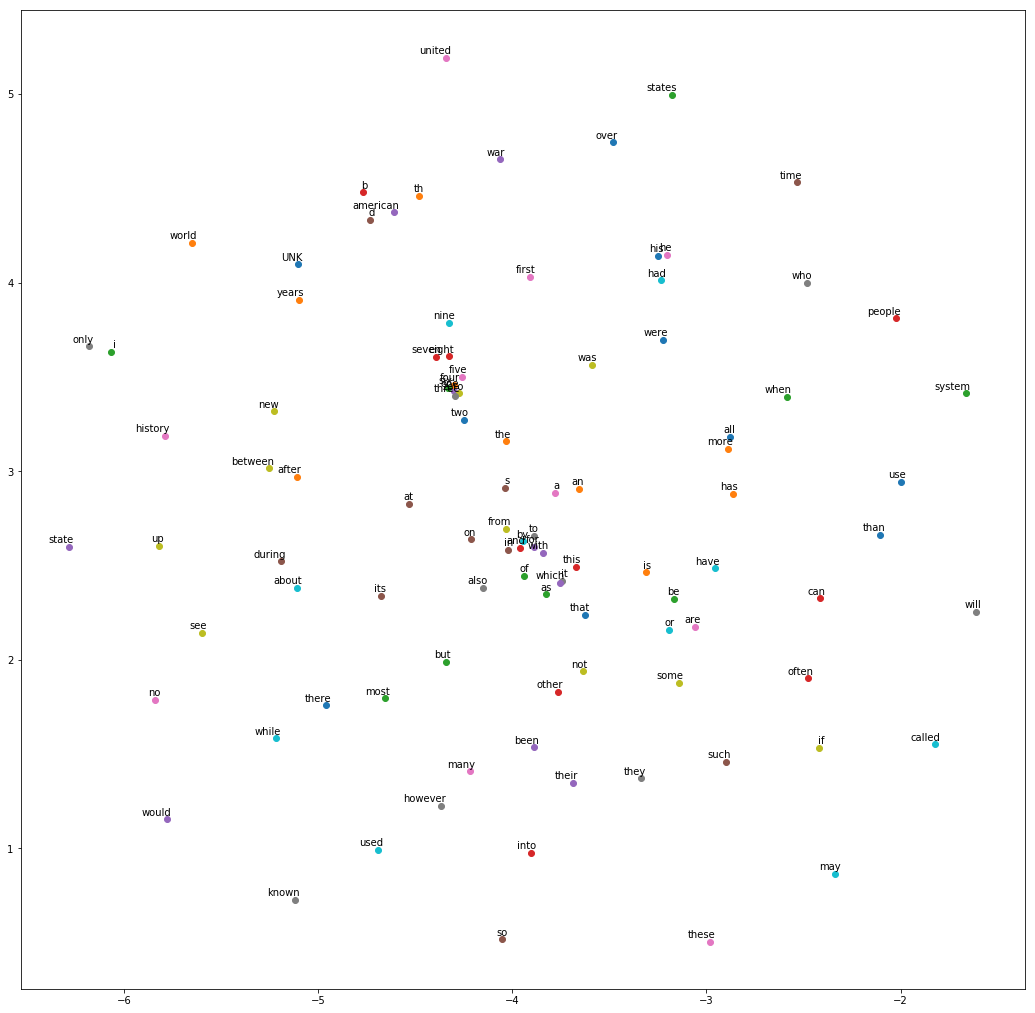

In [9]:
%matplotlib inline
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

  plt.savefig(filename)


try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 100
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

## Evaluation
The below code uses the [kudkudak/word-embeddings-benchmarks package][1] to evaluate the above embeddings on the [Google Analogy test set][2].

 [1]: https://github.com/kudkudak/word-embeddings-benchmarks (Package for evaluating word embeddings)
 [2]: https://aclweb.org/aclwiki/Google_analogy_test_set_(State_of_the_art) (Google analogy test set)

In [50]:
from annoy import AnnoyIndex

n_trees = 100
search_k = 100

annoy_index = AnnoyIndex(embedding_size, metric='angular')
for index, embedding in enumerate(final_embeddings):
    annoy_index.add_item(index, embedding)
annoy_index.build(n_trees)

In [51]:
from web.datasets.analogy import fetch_google_analogy

dataset = fetch_google_analogy()

In [54]:
from __future__ import division

previous_category = dataset.category[0]
trials = {'semantic': [], 'syntactic': [], 'total': []}
missing_words = set()
skipped_trials = 0

def print_acc():
    print('- Semantic accuracy:\t{} %\n- Syntactic accuracy:\t{} %\n- Total accuracy:\t{} %'.format(
        float('nan') if not trials['semantic'] else sum(trials['semantic']) / len(trials['semantic']) * 100,
        float('nan') if not trials['syntactic'] else sum(trials['syntactic']) / len(trials['syntactic']) * 100,
        float('nan') if not trials['total'] else sum(trials['total']) / len(trials['total']) * 100,
    ))
    print('- Missing words:\t{} (skipped {} % of all trials)'.format(
        ', '.join(missing_words),
        float('nan') if not trials['total'] else skipped_trials / len(trials['total']) * 100,
    ))
    print()

for X, y, category, category_high_level in zip(
            dataset.X,
            dataset.y,
            dataset.category,
            dataset.category_high_level
        ):

    if previous_category != category:
        previous_category = category
        print('Current category: {}'.format(category))
        print_acc()

    if X[0] in dictionary and X[1] in dictionary and X[2] in dictionary and y in dictionary:
        u1 = final_embeddings[dictionary[X[0]]]
        v1 = final_embeddings[dictionary[X[1]]]
        u2 = final_embeddings[dictionary[X[2]]]
        v2_index = annoy_index.get_nns_by_vector(u2 + (v1 - u1), 1, search_k)[0]
        v2_word = reverse_dictionary[v2_index]
        print('{} - {} + {} = {} (correct answer: {})'.format(X[1], X[0], X[2], v2_word, y))
        trial_success = v2_word == y
    else:
        if X[0] not in dictionary:
            missing_words.add(X[0])
        if X[1] not in dictionary:
            missing_words.add(X[1])
        if X[2] not in dictionary:
            missing_words.add(X[2])
        if y not in dictionary:
            missing_words.add(y)
        skipped_trials += 1
        trial_success = False
    trials[category_high_level].append(trial_success)
    trials['total'].append(trial_success)

print('Finished!')
print_acc()

greece - athens + baghdad = simulate (ground truth: iraq)
greece - athens + bangkok = appanage (ground truth: thailand)
greece - athens + beijing = beijing (ground truth: china)
greece - athens + berlin = foaling (ground truth: germany)
greece - athens + bern = mikoto (ground truth: switzerland)
greece - athens + cairo = keikogi (ground truth: egypt)
greece - athens + canberra = canberra (ground truth: australia)
greece - athens + hanoi = corticotropin (ground truth: vietnam)
greece - athens + havana = rerum (ground truth: cuba)
greece - athens + helsinki = dotless (ground truth: finland)
greece - athens + islamabad = bunch (ground truth: pakistan)
greece - athens + kabul = kabul (ground truth: afghanistan)
greece - athens + london = pins (ground truth: england)
greece - athens + madrid = trove (ground truth: spain)
greece - athens + moscow = blessed (ground truth: russia)
greece - athens + oslo = cardinal (ground truth: norway)
greece - athens + ottawa = ottawa (ground truth: canada)


france - paris + bern = rsas (ground truth: switzerland)
france - paris + cairo = bipyramid (ground truth: egypt)
france - paris + canberra = gallery (ground truth: australia)
france - paris + hanoi = lehmann (ground truth: vietnam)
france - paris + havana = bouillon (ground truth: cuba)
france - paris + helsinki = brewers (ground truth: finland)
france - paris + islamabad = ohm (ground truth: pakistan)
france - paris + kabul = kabul (ground truth: afghanistan)
france - paris + london = london (ground truth: england)
france - paris + madrid = extinguisher (ground truth: spain)
france - paris + moscow = service (ground truth: russia)
france - paris + oslo = hamizbei (ground truth: norway)
france - paris + ottawa = syrian (ground truth: canada)
italy - rome + stockholm = vicarious (ground truth: sweden)
italy - rome + tehran = pyle (ground truth: iran)
italy - rome + tokyo = biologic (ground truth: japan)
italy - rome + athens = triad (ground truth: greece)
italy - rome + baghdad = italy

eritrea - asmara + gaborone = intercepts (ground truth: botswana)
eritrea - asmara + georgetown = unvenerated (ground truth: guyana)
eritrea - asmara + hanoi = khalsa (ground truth: vietnam)
eritrea - asmara + harare = eritrea (ground truth: zimbabwe)
eritrea - asmara + havana = havana (ground truth: cuba)
eritrea - asmara + helsinki = application (ground truth: finland)
eritrea - asmara + islamabad = looks (ground truth: pakistan)
kazakhstan - astana + athens = usually (ground truth: greece)
kazakhstan - astana + baghdad = kazakhstan (ground truth: iraq)
kazakhstan - astana + baku = kazakhstan (ground truth: azerbaijan)
kazakhstan - astana + bamako = kazakhstan (ground truth: mali)
kazakhstan - astana + bangkok = smaller (ground truth: thailand)
kazakhstan - astana + banjul = dec (ground truth: gambia)
kazakhstan - astana + beijing = chambers (ground truth: china)
kazakhstan - astana + beirut = reaching (ground truth: lebanon)
kazakhstan - astana + belgrade = kazakhstan (ground truth:

belize - belmopan + jakarta = shingles (ground truth: indonesia)
belize - belmopan + kabul = belize (ground truth: afghanistan)
belize - belmopan + kampala = paddlewheeler (ground truth: uganda)
belize - belmopan + kathmandu = peters (ground truth: nepal)
belize - belmopan + khartoum = belize (ground truth: sudan)
belize - belmopan + kiev = tacitus (ground truth: ukraine)
belize - belmopan + kigali = belize (ground truth: rwanda)
belize - belmopan + kingston = bodies (ground truth: jamaica)
belize - belmopan + libreville = belize (ground truth: gabon)
belize - belmopan + lilongwe = associativity (ground truth: malawi)
belize - belmopan + lima = canonical (ground truth: peru)
germany - berlin + bern = northwards (ground truth: switzerland)
germany - berlin + bishkek = paint (ground truth: kyrgyzstan)
germany - berlin + bratislava = holies (ground truth: slovakia)
germany - berlin + brussels = tors (ground truth: belgium)
germany - berlin + bucharest = beatification (ground truth: romani

egypt - cairo + dublin = typically (ground truth: ireland)
egypt - cairo + dushanbe = envisaging (ground truth: tajikistan)
egypt - cairo + gaborone = bonduca (ground truth: botswana)
egypt - cairo + georgetown = himalaya (ground truth: guyana)
egypt - cairo + hanoi = row (ground truth: vietnam)
egypt - cairo + harare = harare (ground truth: zimbabwe)
egypt - cairo + havana = egypt (ground truth: cuba)
egypt - cairo + helsinki = ecumenism (ground truth: finland)
egypt - cairo + islamabad = graz (ground truth: pakistan)
egypt - cairo + jakarta = egypt (ground truth: indonesia)
egypt - cairo + kabul = electricity (ground truth: afghanistan)
egypt - cairo + kampala = elmsley (ground truth: uganda)
egypt - cairo + kathmandu = aegina (ground truth: nepal)
egypt - cairo + khartoum = coherent (ground truth: sudan)
egypt - cairo + kiev = egypt (ground truth: ukraine)
egypt - cairo + kigali = cims (ground truth: rwanda)
egypt - cairo + kingston = zion (ground truth: jamaica)
egypt - cairo + lib

ireland - dublin + kiev = resilient (ground truth: ukraine)
ireland - dublin + kigali = maricopa (ground truth: rwanda)
ireland - dublin + kingston = ireland (ground truth: jamaica)
ireland - dublin + libreville = inaccessability (ground truth: gabon)
ireland - dublin + lilongwe = stine (ground truth: malawi)
ireland - dublin + lima = lima (ground truth: peru)
ireland - dublin + lisbon = buhring (ground truth: portugal)
ireland - dublin + ljubljana = exceedingly (ground truth: slovenia)
ireland - dublin + london = husa (ground truth: england)
ireland - dublin + luanda = ireland (ground truth: angola)
ireland - dublin + lusaka = unrepresentative (ground truth: zambia)
ireland - dublin + madrid = magnetopause (ground truth: spain)
ireland - dublin + managua = airport (ground truth: nicaragua)
ireland - dublin + manama = tf (ground truth: bahrain)
ireland - dublin + manila = histidine (ground truth: philippines)
ireland - dublin + maputo = syriac (ground truth: mozambique)
ireland - dubli

indonesia - jakarta + kingston = indonesia (ground truth: jamaica)
indonesia - jakarta + libreville = hittites (ground truth: gabon)
indonesia - jakarta + lilongwe = cheerfully (ground truth: malawi)
indonesia - jakarta + lima = dympna (ground truth: peru)
indonesia - jakarta + lisbon = holdings (ground truth: portugal)
indonesia - jakarta + ljubljana = matter (ground truth: slovenia)
indonesia - jakarta + london = alcohol (ground truth: england)
indonesia - jakarta + luanda = consumed (ground truth: angola)
indonesia - jakarta + lusaka = lusaka (ground truth: zambia)
indonesia - jakarta + madrid = cpus (ground truth: spain)
indonesia - jakarta + managua = menses (ground truth: nicaragua)
indonesia - jakarta + manama = addressee (ground truth: bahrain)
indonesia - jakarta + manila = bres (ground truth: philippines)
indonesia - jakarta + maputo = bauhaus (ground truth: mozambique)
indonesia - jakarta + minsk = ultraman (ground truth: belarus)
indonesia - jakarta + mogadishu = mogadishu 

peru - lima + rome = rome (ground truth: italy)
peru - lima + roseau = dhv (ground truth: dominica)
peru - lima + santiago = than (ground truth: chile)
peru - lima + skopje = skopje (ground truth: macedonia)
peru - lima + sofia = peru (ground truth: bulgaria)
peru - lima + stockholm = stockholm (ground truth: sweden)
peru - lima + suva = lagadha (ground truth: fiji)
peru - lima + taipei = italy (ground truth: taiwan)
peru - lima + tallinn = terboven (ground truth: estonia)
portugal - lisbon + ljubljana = luthier (ground truth: slovenia)
portugal - lisbon + london = fide (ground truth: england)
portugal - lisbon + luanda = vous (ground truth: angola)
portugal - lisbon + lusaka = turned (ground truth: zambia)
portugal - lisbon + madrid = midway (ground truth: spain)
portugal - lisbon + managua = backbrain (ground truth: nicaragua)
portugal - lisbon + manama = derailed (ground truth: bahrain)
portugal - lisbon + manila = godhead (ground truth: philippines)
portugal - lisbon + maputo = her

somalia - mogadishu + muscat = paternity (ground truth: oman)
somalia - mogadishu + nairobi = atreides (ground truth: kenya)
somalia - mogadishu + nassau = sparring (ground truth: bahamas)
somalia - mogadishu + nicosia = somalia (ground truth: cyprus)
somalia - mogadishu + nouakchott = isotopic (ground truth: mauritania)
somalia - mogadishu + nuuk = cleansed (ground truth: greenland)
somalia - mogadishu + oslo = zero (ground truth: norway)
somalia - mogadishu + ottawa = somalia (ground truth: canada)
somalia - mogadishu + paramaribo = smollett (ground truth: suriname)
somalia - mogadishu + paris = somalia (ground truth: france)
somalia - mogadishu + podgorica = brogniart (ground truth: montenegro)
somalia - mogadishu + quito = quito (ground truth: ecuador)
somalia - mogadishu + rabat = rabat (ground truth: morocco)
somalia - mogadishu + riga = belarusians (ground truth: latvia)
somalia - mogadishu + rome = two (ground truth: italy)
somalia - mogadishu + roseau = imail (ground truth: do

norway - oslo + riga = riga (ground truth: latvia)
norway - oslo + rome = rome (ground truth: italy)
norway - oslo + roseau = ferdowsi (ground truth: dominica)
norway - oslo + santiago = dollar (ground truth: chile)
norway - oslo + skopje = sharks (ground truth: macedonia)
norway - oslo + sofia = emperor (ground truth: bulgaria)
norway - oslo + stockholm = emperor (ground truth: sweden)
norway - oslo + suva = lland (ground truth: fiji)
norway - oslo + taipei = discontinued (ground truth: taiwan)
norway - oslo + tallinn = cave (ground truth: estonia)
norway - oslo + tashkent = katabna (ground truth: uzbekistan)
norway - oslo + tbilisi = mysteriorum (ground truth: georgia)
norway - oslo + tegucigalpa = dr (ground truth: honduras)
norway - oslo + tehran = hitman (ground truth: iran)
norway - oslo + tirana = kitelbjorn (ground truth: albania)
norway - oslo + tokyo = saklas (ground truth: japan)
norway - oslo + tripoli = thirteen (ground truth: libya)
norway - oslo + tunis = gliders (ground

macedonia - skopje + taipei = macedonia (ground truth: taiwan)
macedonia - skopje + tallinn = augustine (ground truth: estonia)
macedonia - skopje + tashkent = witold (ground truth: uzbekistan)
macedonia - skopje + tbilisi = tbilisi (ground truth: georgia)
macedonia - skopje + tegucigalpa = tegucigalpa (ground truth: honduras)
macedonia - skopje + tehran = expansionary (ground truth: iran)
macedonia - skopje + tirana = coro (ground truth: albania)
macedonia - skopje + tokyo = tokyo (ground truth: japan)
macedonia - skopje + tripoli = macedonia (ground truth: libya)
macedonia - skopje + tunis = fragments (ground truth: tunisia)
macedonia - skopje + vaduz = grabar (ground truth: liechtenstein)
macedonia - skopje + valletta = fv (ground truth: malta)
macedonia - skopje + vienna = baden (ground truth: austria)
macedonia - skopje + vientiane = shahanshah (ground truth: laos)
macedonia - skopje + vilnius = vilnius (ground truth: lithuania)
macedonia - skopje + warsaw = warsaw (ground truth: 

iran - tehran + belgrade = groove (ground truth: serbia)
iran - tehran + belmopan = kenderaan (ground truth: belize)
iran - tehran + berlin = presidential (ground truth: germany)
iran - tehran + bern = bern (ground truth: switzerland)
iran - tehran + bishkek = kosmonavt (ground truth: kyrgyzstan)
iran - tehran + bratislava = fairway (ground truth: slovakia)
iran - tehran + brussels = itself (ground truth: belgium)
albania - tirana + tokyo = jagger (ground truth: japan)
albania - tirana + tripoli = asl (ground truth: libya)
albania - tirana + tunis = mania (ground truth: tunisia)
albania - tirana + vaduz = vaduz (ground truth: liechtenstein)
albania - tirana + valletta = valletta (ground truth: malta)
albania - tirana + vienna = albania (ground truth: austria)
albania - tirana + vientiane = midlands (ground truth: laos)
albania - tirana + vilnius = strategies (ground truth: lithuania)
albania - tirana + warsaw = the (ground truth: poland)
albania - tirana + windhoek = ophir (ground trut

namibia - windhoek + bern = masai (ground truth: switzerland)
namibia - windhoek + bishkek = bean (ground truth: kyrgyzstan)
namibia - windhoek + bratislava = bratislava (ground truth: slovakia)
namibia - windhoek + brussels = bios (ground truth: belgium)
namibia - windhoek + bucharest = bucharest (ground truth: romania)
namibia - windhoek + budapest = evolutionarily (ground truth: hungary)
namibia - windhoek + bujumbura = quartz (ground truth: burundi)
namibia - windhoek + cairo = bean (ground truth: egypt)
namibia - windhoek + canberra = used (ground truth: australia)
namibia - windhoek + caracas = chaldean (ground truth: venezuela)
namibia - windhoek + chisinau = lured (ground truth: moldova)
namibia - windhoek + conakry = haggis (ground truth: guinea)
namibia - windhoek + copenhagen = namibia (ground truth: denmark)
namibia - windhoek + dakar = dakar (ground truth: senegal)
namibia - windhoek + damascus = praxis (ground truth: syria)
namibia - windhoek + dhaka = dhaka (ground truth

kuna - croatia + cambodia = hucks (ground truth: riel)
kuna - croatia + canada = beinfest (ground truth: dollar)
krone - denmark + europe = krone (ground truth: euro)
krone - denmark + hungary = engram (ground truth: forint)
krone - denmark + india = mcneil (ground truth: rupee)
krone - denmark + iran = eating (ground truth: rial)
krone - denmark + japan = zelman (ground truth: yen)
krone - denmark + korea = campanella (ground truth: won)
krone - denmark + latvia = bagdad (ground truth: lats)
krone - denmark + lithuania = ossets (ground truth: litas)
krone - denmark + macedonia = jiabao (ground truth: denar)
krone - denmark + malaysia = keik (ground truth: ringgit)
krone - denmark + mexico = thompson (ground truth: peso)
krone - denmark + nigeria = krone (ground truth: naira)
krone - denmark + poland = monck (ground truth: zloty)
krone - denmark + romania = miti (ground truth: leu)
krone - denmark + russia = anal (ground truth: ruble)
krone - denmark + sweden = plantagenet (ground trut

zloty - poland + croatia = faidutti (ground truth: kuna)
zloty - poland + denmark = catarrhal (ground truth: krone)
zloty - poland + europe = ishiro (ground truth: euro)
zloty - poland + hungary = jayasuriya (ground truth: forint)
zloty - poland + india = panzaleo (ground truth: rupee)
zloty - poland + iran = issn (ground truth: rial)
zloty - poland + japan = ishiro (ground truth: yen)
zloty - poland + korea = dyakooyem (ground truth: won)
zloty - poland + latvia = orycteropodidae (ground truth: lats)
zloty - poland + lithuania = zloty (ground truth: litas)
zloty - poland + macedonia = sharjah (ground truth: denar)
zloty - poland + malaysia = prodigy (ground truth: ringgit)
zloty - poland + mexico = raroia (ground truth: peso)
zloty - poland + nigeria = karnatak (ground truth: naira)
leu - romania + russia = means (ground truth: ruble)
leu - romania + sweden = adapts (ground truth: krona)
leu - romania + thailand = thermidor (ground truth: baht)
leu - romania + ukraine = award (ground 

florida - jacksonville + baltimore = trek (ground truth: maryland)
florida - jacksonville + nashville = autoantibodies (ground truth: tennessee)
florida - jacksonville + louisville = louisville (ground truth: kentucky)
florida - jacksonville + milwaukee = florida (ground truth: wisconsin)
florida - jacksonville + portland = florida (ground truth: oregon)
florida - jacksonville + tucson = tidings (ground truth: arizona)
florida - jacksonville + fresno = abrahadabra (ground truth: california)
florida - jacksonville + sacramento = florida (ground truth: california)
florida - jacksonville + mesa = pesce (ground truth: arizona)
florida - jacksonville + atlanta = persons (ground truth: georgia)
florida - jacksonville + omaha = pierced (ground truth: nebraska)
florida - jacksonville + tulsa = identidem (ground truth: oklahoma)
florida - jacksonville + oakland = oakland (ground truth: california)
florida - jacksonville + cleveland = au (ground truth: ohio)
florida - jacksonville + minneapolis 

kentucky - louisville + anaheim = matured (ground truth: california)
kentucky - louisville + honolulu = kentucky (ground truth: hawaii)
kentucky - louisville + pittsburgh = kentucky (ground truth: pennsylvania)
kentucky - louisville + stockton = lackey (ground truth: california)
kentucky - louisville + cincinnati = authorship (ground truth: ohio)
kentucky - louisville + anchorage = kentucky (ground truth: alaska)
kentucky - louisville + toledo = qin (ground truth: ohio)
kentucky - louisville + plano = portfolio (ground truth: texas)
kentucky - louisville + henderson = recognize (ground truth: nevada)
kentucky - louisville + orlando = gry (ground truth: florida)
kentucky - louisville + laredo = mistakenly (ground truth: texas)
kentucky - louisville + chandler = resolutions (ground truth: arizona)
kentucky - louisville + madison = railroads (ground truth: wisconsin)
kentucky - louisville + lubbock = hosea (ground truth: texas)
kentucky - louisville + garland = cary (ground truth: texas)


california - oakland + irving = accurately (ground truth: texas)
california - oakland + spokane = teruyoshi (ground truth: washington)
california - oakland + shreveport = loverly (ground truth: louisiana)
california - oakland + tacoma = california (ground truth: washington)
california - oakland + akron = toast (ground truth: ohio)
california - oakland + amarillo = gyojasang (ground truth: texas)
california - oakland + tallahassee = nabta (ground truth: florida)
ohio - cleveland + minneapolis = ohio (ground truth: minnesota)
ohio - cleveland + wichita = ohio (ground truth: kansas)
ohio - cleveland + arlington = ohio (ground truth: texas)
ohio - cleveland + bakersfield = sincere (ground truth: california)
ohio - cleveland + tampa = entscheidungsproblem (ground truth: florida)
ohio - cleveland + anaheim = compsognathus (ground truth: california)
ohio - cleveland + honolulu = proposition (ground truth: hawaii)
ohio - cleveland + pittsburgh = ohio (ground truth: pennsylvania)
ohio - clevela

ohio - cincinnati + dallas = lusers (ground truth: texas)
ohio - cincinnati + jacksonville = ohio (ground truth: florida)
ohio - cincinnati + indianapolis = indianapolis (ground truth: indiana)
ohio - cincinnati + austin = tuberculatus (ground truth: texas)
ohio - cincinnati + detroit = completeness (ground truth: michigan)
ohio - cincinnati + memphis = commit (ground truth: tennessee)
alaska - anchorage + toledo = soma (ground truth: ohio)
alaska - anchorage + plano = retconned (ground truth: texas)
alaska - anchorage + henderson = fataar (ground truth: nevada)
alaska - anchorage + orlando = alaska (ground truth: florida)
alaska - anchorage + laredo = loos (ground truth: texas)
alaska - anchorage + chandler = evoked (ground truth: arizona)
alaska - anchorage + madison = illyria (ground truth: wisconsin)
alaska - anchorage + lubbock = thaler (ground truth: texas)
alaska - anchorage + garland = lumbar (ground truth: texas)
alaska - anchorage + glendale = mpg (ground truth: arizona)
alas

florida - hialeah + shreveport = spinoza (ground truth: louisiana)
florida - hialeah + tacoma = group (ground truth: washington)
florida - hialeah + oxnard = ambiguity (ground truth: california)
florida - hialeah + fontana = vacant (ground truth: california)
florida - hialeah + akron = blockage (ground truth: ohio)
florida - hialeah + amarillo = studies (ground truth: texas)
florida - hialeah + glendale = florida (ground truth: california)
florida - hialeah + huntsville = florida (ground truth: alabama)
florida - hialeah + worcester = worcester (ground truth: massachusetts)
florida - hialeah + chicago = to (ground truth: illinois)
florida - hialeah + houston = speaker (ground truth: texas)
florida - hialeah + philadelphia = florida (ground truth: pennsylvania)
florida - hialeah + phoenix = florida (ground truth: arizona)
florida - hialeah + dallas = florida (ground truth: texas)
florida - hialeah + indianapolis = adjustments (ground truth: indiana)
florida - hialeah + austin = in (grou

california - fontana + phoenix = elevating (ground truth: arizona)
california - fontana + dallas = california (ground truth: texas)
california - fontana + jacksonville = rgev (ground truth: florida)
california - fontana + indianapolis = california (ground truth: indiana)
california - fontana + austin = california (ground truth: texas)
california - fontana + detroit = detroit (ground truth: michigan)
california - fontana + memphis = orbitals (ground truth: tennessee)
california - fontana + boston = boston (ground truth: massachusetts)
california - fontana + seattle = archaelogical (ground truth: washington)
california - fontana + denver = california (ground truth: colorado)
california - fontana + baltimore = hallucinogen (ground truth: maryland)
california - fontana + nashville = student (ground truth: tennessee)
california - fontana + louisville = mourned (ground truth: kentucky)
california - fontana + milwaukee = milwaukee (ground truth: wisconsin)
california - fontana + portland = so

granddaughter - grandson + king = barrett (ground truth: queen)
granddaughter - grandson + man = increasingly (ground truth: woman)
granddaughter - grandson + nephew = camping (ground truth: niece)
granddaughter - grandson + policeman = policeman (ground truth: policewoman)
granddaughter - grandson + prince = granddaughter (ground truth: princess)
granddaughter - grandson + son = claudius (ground truth: daughter)
granddaughter - grandson + sons = brandname (ground truth: daughters)
granddaughter - grandson + stepbrother = dikson (ground truth: stepsister)
granddaughter - grandson + stepfather = stringy (ground truth: stepmother)
granddaughter - grandson + stepson = smitrovich (ground truth: stepdaughter)
granddaughter - grandson + uncle = remnant (ground truth: aunt)
granddaughter - grandson + boy = digital (ground truth: girl)
granddaughter - grandson + brother = champagne (ground truth: sister)
granddaughter - grandson + brothers = burghers (ground truth: sisters)
granddaughter - gra

calmly - calm + immediate = hcn (ground truth: immediately)
calmly - calm + infrequent = brokerage (ground truth: infrequently)
calmly - calm + lucky = cumbia (ground truth: luckily)
calmly - calm + most = calmly (ground truth: mostly)
calmly - calm + obvious = suited (ground truth: obviously)
calmly - calm + occasional = calcined (ground truth: occasionally)
calmly - calm + possible = internment (ground truth: possibly)
calmly - calm + precise = bundeskanzler (ground truth: precisely)
calmly - calm + professional = westernization (ground truth: professionally)
calmly - calm + quick = quick (ground truth: quickly)
calmly - calm + quiet = rinsing (ground truth: quietly)
calmly - calm + rapid = permeability (ground truth: rapidly)
calmly - calm + rare = kemo (ground truth: rarely)
calmly - calm + reluctant = reluctant (ground truth: reluctantly)
calmly - calm + safe = beeps (ground truth: safely)
calmly - calm + serious = calmly (ground truth: seriously)
calmly - calm + slow = subtlest (

occasionally - occasional + amazing = anson (ground truth: amazingly)
occasionally - occasional + apparent = highways (ground truth: apparently)
occasionally - occasional + calm = etudes (ground truth: calmly)
occasionally - occasional + cheerful = manifest (ground truth: cheerfully)
occasionally - occasional + complete = occasionally (ground truth: completely)
occasionally - occasional + efficient = terminology (ground truth: efficiently)
occasionally - occasional + fortunate = occasionally (ground truth: fortunately)
occasionally - occasional + free = free (ground truth: freely)
occasionally - occasional + furious = several (ground truth: furiously)
occasionally - occasional + happy = occasionally (ground truth: happily)
occasionally - occasional + immediate = occasionally (ground truth: immediately)
occasionally - occasional + infrequent = derrek (ground truth: infrequently)
occasionally - occasional + lucky = hussein (ground truth: luckily)
occasionally - occasional + most = proven

swiftly - swift + apparent = swiftly (ground truth: apparently)
swiftly - swift + calm = snoop (ground truth: calmly)
swiftly - swift + cheerful = metasyntactic (ground truth: cheerfully)
swiftly - swift + complete = column (ground truth: completely)
swiftly - swift + efficient = bsec (ground truth: efficiently)
swiftly - swift + fortunate = mainyu (ground truth: fortunately)
swiftly - swift + free = espousing (ground truth: freely)
swiftly - swift + furious = karmic (ground truth: furiously)
swiftly - swift + happy = milieu (ground truth: happily)
swiftly - swift + immediate = impetus (ground truth: immediately)
swiftly - swift + infrequent = palpatine (ground truth: infrequently)
swiftly - swift + lucky = genealogies (ground truth: luckily)
swiftly - swift + most = sul (ground truth: mostly)
swiftly - swift + obvious = casale (ground truth: obviously)
swiftly - swift + occasional = extropianism (ground truth: occasionally)
swiftly - swift + possible = rebekah (ground truth: possibly)

inefficient - efficient + convenient = pupils (ground truth: inconvenient)
inefficient - efficient + decided = forthwith (ground truth: undecided)
unethical - ethical + fortunate = redirected (ground truth: unfortunate)
unethical - ethical + honest = mezzotinting (ground truth: dishonest)
unethical - ethical + impressive = viollet (ground truth: unimpressive)
unethical - ethical + informative = cooperates (ground truth: uninformative)
unethical - ethical + informed = unethical (ground truth: uninformed)
unethical - ethical + known = rehearsing (ground truth: unknown)
unethical - ethical + likely = rtl (ground truth: unlikely)
unethical - ethical + logical = convention (ground truth: illogical)
unethical - ethical + pleasant = responsive (ground truth: unpleasant)
unethical - ethical + possible = unethical (ground truth: impossible)
unethical - ethical + possibly = kroq (ground truth: impossibly)
unethical - ethical + productive = ethnographers (ground truth: unproductive)
unethical - e

irresponsible - responsible + decided = irresponsible (ground truth: undecided)
irresponsible - responsible + efficient = asucd (ground truth: inefficient)
irresponsible - responsible + ethical = artistes (ground truth: unethical)
irresponsible - responsible + fortunate = propertied (ground truth: unfortunate)
irresponsible - responsible + honest = utensil (ground truth: dishonest)
irresponsible - responsible + impressive = electorate (ground truth: unimpressive)
irresponsible - responsible + informative = eastchester (ground truth: uninformative)
irresponsible - responsible + informed = maupassant (ground truth: uninformed)
irresponsible - responsible + known = referendum (ground truth: unknown)
irresponsible - responsible + likely = nordmann (ground truth: unlikely)
irresponsible - responsible + logical = irresponsible (ground truth: illogical)
irresponsible - responsible + pleasant = husbyfj (ground truth: unpleasant)
irresponsible - responsible + possible = tyrol (ground truth: imp

better - good + new = latrobe (ground truth: newer)
better - good + old = olbers (ground truth: older)
better - good + quick = creating (ground truth: quicker)
better - good + safe = finisher (ground truth: safer)
better - good + sharp = veterinarian (ground truth: sharper)
better - good + short = aerobic (ground truth: shorter)
better - good + simple = asp (ground truth: simpler)
better - good + slow = telephones (ground truth: slower)
better - good + small = material (ground truth: smaller)
better - good + smart = obstacles (ground truth: smarter)
better - good + strong = telephones (ground truth: stronger)
better - good + tall = tall (ground truth: taller)
better - good + tight = or (ground truth: tighter)
better - good + tough = better (ground truth: tougher)
better - good + warm = olbers (ground truth: warmer)
better - good + weak = db (ground truth: weaker)
better - good + wide = wide (ground truth: wider)
better - good + young = transylvania (ground truth: younger)
better - good

older - old + wide = wide (ground truth: wider)
older - old + young = leeds (ground truth: younger)
older - old + bad = buddy (ground truth: worse)
older - old + big = big (ground truth: bigger)
older - old + bright = inlay (ground truth: brighter)
older - old + cheap = disagree (ground truth: cheaper)
older - old + cold = barthes (ground truth: colder)
older - old + cool = kinds (ground truth: cooler)
older - old + deep = warlord (ground truth: deeper)
older - old + easy = shepherds (ground truth: easier)
older - old + fast = opcw (ground truth: faster)
older - old + good = rod (ground truth: better)
older - old + great = great (ground truth: greater)
older - old + hard = inlay (ground truth: harder)
older - old + heavy = heavy (ground truth: heavier)
older - old + high = millennia (ground truth: higher)
older - old + hot = paths (ground truth: hotter)
older - old + large = older (ground truth: larger)
older - old + long = older (ground truth: longer)
older - old + loud = attaches (gr

tighter - tight + weak = usages (ground truth: weaker)
tighter - tight + wide = belisarius (ground truth: wider)
tighter - tight + young = nervosa (ground truth: younger)
tighter - tight + bad = bad (ground truth: worse)
tighter - tight + big = setu (ground truth: bigger)
tighter - tight + bright = radiocarbon (ground truth: brighter)
tighter - tight + cheap = devanagari (ground truth: cheaper)
tighter - tight + cold = caravans (ground truth: colder)
tighter - tight + cool = usages (ground truth: cooler)
tighter - tight + deep = umm (ground truth: deeper)
tighter - tight + easy = armada (ground truth: easier)
tighter - tight + fast = gudulae (ground truth: faster)
tighter - tight + good = sammy (ground truth: better)
tighter - tight + great = thru (ground truth: greater)
tighter - tight + hard = plane (ground truth: harder)
tighter - tight + heavy = selfconscious (ground truth: heavier)
tighter - tight + high = organisations (ground truth: higher)
tighter - tight + hot = armada (ground

darkest - dark + cold = darkest (ground truth: coldest)
darkest - dark + cool = ejective (ground truth: coolest)
easiest - easy + fast = easiest (ground truth: fastest)
easiest - easy + good = determination (ground truth: best)
easiest - easy + great = amphibian (ground truth: greatest)
easiest - easy + high = easiest (ground truth: highest)
easiest - easy + hot = hot (ground truth: hottest)
easiest - easy + large = shook (ground truth: largest)
easiest - easy + long = ulema (ground truth: longest)
easiest - easy + low = lv (ground truth: lowest)
easiest - easy + lucky = rpr (ground truth: luckiest)
easiest - easy + old = easiest (ground truth: oldest)
easiest - easy + quick = focussed (ground truth: quickest)
easiest - easy + sharp = hemlock (ground truth: sharpest)
easiest - easy + simple = conjunction (ground truth: simplest)
easiest - easy + short = electrophilic (ground truth: shortest)
easiest - easy + slow = zoological (ground truth: slowest)
easiest - easy + small = lengthened 

simplest - simple + strange = islets (ground truth: strangest)
simplest - simple + strong = moseley (ground truth: strongest)
simplest - simple + sweet = sweet (ground truth: sweetest)
simplest - simple + tall = why (ground truth: tallest)
simplest - simple + warm = partners (ground truth: warmest)
simplest - simple + weak = measure (ground truth: weakest)
simplest - simple + wide = alekhine (ground truth: widest)
simplest - simple + young = roine (ground truth: youngest)
simplest - simple + bad = isis (ground truth: worst)
simplest - simple + big = herman (ground truth: biggest)
simplest - simple + bright = inconsequential (ground truth: brightest)
simplest - simple + cold = trench (ground truth: coldest)
simplest - simple + cool = guinness (ground truth: coolest)
simplest - simple + dark = estonian (ground truth: darkest)
simplest - simple + easy = laity (ground truth: easiest)
simplest - simple + fast = menezes (ground truth: fastest)
simplest - simple + good = flunitrazepam (ground

coding - code + play = socialism (ground truth: playing)
coding - code + predict = tukhachevsky (ground truth: predicting)
coding - code + read = antiparticle (ground truth: reading)
coding - code + run = a (ground truth: running)
coding - code + say = principles (ground truth: saying)
coding - code + scream = streetcars (ground truth: screaming)
coding - code + see = priscus (ground truth: seeing)
coding - code + shuffle = hails (ground truth: shuffling)
coding - code + sing = layne (ground truth: singing)
coding - code + sit = mathematica (ground truth: sitting)
coding - code + slow = a (ground truth: slowing)
coding - code + swim = nationalisation (ground truth: swimming)
coding - code + think = bound (ground truth: thinking)
coding - code + vanish = remission (ground truth: vanishing)
coding - code + walk = heinz (ground truth: walking)
coding - code + write = farms (ground truth: writing)
dancing - dance + debug = ozell (ground truth: debugging)
dancing - dance + decrease = illega

jumping - jump + say = rorschach (ground truth: saying)
jumping - jump + scream = remarkably (ground truth: screaming)
jumping - jump + see = kore (ground truth: seeing)
jumping - jump + shuffle = grana (ground truth: shuffling)
jumping - jump + sing = kilauea (ground truth: singing)
jumping - jump + sit = deflagration (ground truth: sitting)
jumping - jump + slow = slow (ground truth: slowing)
jumping - jump + swim = kab (ground truth: swimming)
jumping - jump + think = unorthodox (ground truth: thinking)
jumping - jump + vanish = jumping (ground truth: vanishing)
jumping - jump + walk = jumping (ground truth: walking)
jumping - jump + write = jumping (ground truth: writing)
jumping - jump + code = insomnia (ground truth: coding)
jumping - jump + dance = jumping (ground truth: dancing)
jumping - jump + debug = vesicles (ground truth: debugging)
jumping - jump + decrease = rainfall (ground truth: decreasing)
jumping - jump + describe = jumping (ground truth: describing)
jumping - jump 

shuffling - shuffle + run = schwas (ground truth: running)
shuffling - shuffle + say = say (ground truth: saying)
shuffling - shuffle + scream = vandalised (ground truth: screaming)
shuffling - shuffle + see = an (ground truth: seeing)
singing - sing + sit = mecca (ground truth: sitting)
singing - sing + slow = clubs (ground truth: slowing)
singing - sing + swim = singing (ground truth: swimming)
singing - sing + think = defining (ground truth: thinking)
singing - sing + vanish = troublesome (ground truth: vanishing)
singing - sing + walk = maddern (ground truth: walking)
singing - sing + write = kabbalist (ground truth: writing)
singing - sing + code = i (ground truth: coding)
singing - sing + dance = succinct (ground truth: dancing)
singing - sing + debug = psych (ground truth: debugging)
singing - sing + decrease = burgos (ground truth: decreasing)
singing - sing + describe = balanced (ground truth: describing)
singing - sing + discover = kinky (ground truth: discovering)
singing - 

austrian - austria + peru = stimulants (ground truth: peruvian)
austrian - austria + poland = hoderich (ground truth: polish)
austrian - austria + portugal = temporarily (ground truth: portuguese)
austrian - austria + russia = sol (ground truth: russian)
austrian - austria + slovakia = tradespersons (ground truth: slovakian)
austrian - austria + spain = spain (ground truth: spanish)
austrian - austria + sweden = physiologist (ground truth: swedish)
austrian - austria + switzerland = austrian (ground truth: swiss)
austrian - austria + thailand = erase (ground truth: thai)
austrian - austria + ukraine = forestall (ground truth: ukrainian)
austrian - austria + albania = hallways (ground truth: albanian)
austrian - austria + argentina = austrian (ground truth: argentinean)
belorussian - belarus + brazil = plkk (ground truth: brazilian)
belorussian - belarus + bulgaria = biconditionals (ground truth: bulgarian)
belorussian - belarus + cambodia = gisors (ground truth: cambodian)
belorussian 

english - england + poland = demanded (ground truth: polish)
english - england + portugal = robertson (ground truth: portuguese)
english - england + russia = russia (ground truth: russian)
english - england + slovakia = tiun (ground truth: slovakian)
english - england + spain = english (ground truth: spanish)
english - england + sweden = kz (ground truth: swedish)
english - england + switzerland = passy (ground truth: swiss)
english - england + thailand = thailand (ground truth: thai)
english - england + ukraine = one (ground truth: ukrainian)
english - england + albania = pianist (ground truth: albanian)
english - england + argentina = encryption (ground truth: argentinean)
english - england + australia = mho (ground truth: australian)
english - england + austria = feminine (ground truth: austrian)
english - england + belarus = belarus (ground truth: belorussian)
english - england + brazil = ivan (ground truth: brazilian)
english - england + bulgaria = bulgaria (ground truth: bulgaria

korean - korea + greece = fallibility (ground truth: greek)
korean - korea + iceland = refinements (ground truth: icelandic)
korean - korea + india = slippery (ground truth: indian)
korean - korea + ireland = moneghetti (ground truth: irish)
korean - korea + israel = scweb (ground truth: israeli)
korean - korea + italy = oxidative (ground truth: italian)
macedonian - macedonia + malta = posey (ground truth: maltese)
macedonian - macedonia + mexico = skeireins (ground truth: mexican)
macedonian - macedonia + moldova = macedonian (ground truth: moldovan)
macedonian - macedonia + netherlands = netherlands (ground truth: dutch)
macedonian - macedonia + norway = icelandology (ground truth: norwegian)
macedonian - macedonia + peru = playwrights (ground truth: peruvian)
macedonian - macedonia + poland = processors (ground truth: polish)
macedonian - macedonia + portugal = numismatics (ground truth: portuguese)
macedonian - macedonia + russia = russia (ground truth: russian)
macedonian - maced

slovakian - slovakia + colombia = vingt (ground truth: colombian)
slovakian - slovakia + croatia = frenchmen (ground truth: croatian)
slovakian - slovakia + denmark = liability (ground truth: danish)
slovakian - slovakia + egypt = concoctions (ground truth: egyptian)
slovakian - slovakia + england = murals (ground truth: english)
slovakian - slovakia + france = asoka (ground truth: french)
slovakian - slovakia + germany = frenchmen (ground truth: german)
slovakian - slovakia + greece = aravalli (ground truth: greek)
slovakian - slovakia + iceland = cabana (ground truth: icelandic)
slovakian - slovakia + india = coraciiformes (ground truth: indian)
slovakian - slovakia + ireland = sake (ground truth: irish)
slovakian - slovakia + israel = props (ground truth: israeli)
slovakian - slovakia + italy = paglia (ground truth: italian)
slovakian - slovakia + japan = yvon (ground truth: japanese)
slovakian - slovakia + korea = euthanasic (ground truth: korean)
slovakian - slovakia + macedonia =

fell - falling + moving = his (ground truth: moved)
fell - falling + paying = portland (ground truth: paid)
fell - falling + playing = slogans (ground truth: played)
fell - falling + predicting = sentries (ground truth: predicted)
fell - falling + reading = depiction (ground truth: read)
fell - falling + running = arc (ground truth: ran)
fell - falling + saying = tombs (ground truth: said)
fell - falling + screaming = olympiad (ground truth: screamed)
fell - falling + seeing = locrian (ground truth: saw)
fell - falling + selling = housing (ground truth: sold)
fell - falling + shrinking = fell (ground truth: shrank)
fell - falling + singing = fell (ground truth: sang)
fell - falling + sitting = incidence (ground truth: sat)
fell - falling + sleeping = unnamed (ground truth: slept)
fell - falling + slowing = blinded (ground truth: slowed)
fell - falling + spending = huge (ground truth: spent)
fell - falling + striking = fell (ground truth: struck)
fell - falling + swimming = binn (ground

knew - knowing + enhancing = qwerty (ground truth: enhanced)
knew - knowing + falling = lilac (ground truth: fell)
knew - knowing + feeding = presupposes (ground truth: fed)
knew - knowing + flying = gregory (ground truth: flew)
knew - knowing + generating = generating (ground truth: generated)
knew - knowing + going = omri (ground truth: went)
knew - knowing + hiding = ollie (ground truth: hid)
knew - knowing + hitting = ales (ground truth: hit)
knew - knowing + implementing = implementing (ground truth: implemented)
knew - knowing + increasing = increasing (ground truth: increased)
knew - knowing + jumping = cyberspace (ground truth: jumped)
listened - listening + looking = introducing (ground truth: looked)
listened - listening + moving = fg (ground truth: moved)
listened - listening + paying = crown (ground truth: paid)
listened - listening + playing = mp (ground truth: played)
listened - listening + predicting = localization (ground truth: predicted)
listened - listening + reading

saw - seeing + slowing = statements (ground truth: slowed)
saw - seeing + spending = saw (ground truth: spent)
saw - seeing + striking = saw (ground truth: struck)
saw - seeing + swimming = saw (ground truth: swam)
saw - seeing + taking = saw (ground truth: took)
saw - seeing + thinking = continue (ground truth: thought)
saw - seeing + vanishing = nwmp (ground truth: vanished)
saw - seeing + walking = dentist (ground truth: walked)
saw - seeing + writing = tni (ground truth: wrote)
saw - seeing + dancing = saw (ground truth: danced)
saw - seeing + decreasing = saw (ground truth: decreased)
saw - seeing + describing = saw (ground truth: described)
saw - seeing + enhancing = massacre (ground truth: enhanced)
saw - seeing + falling = saw (ground truth: fell)
saw - seeing + feeding = feeding (ground truth: fed)
saw - seeing + flying = saw (ground truth: flew)
saw - seeing + generating = interscope (ground truth: generated)
saw - seeing + going = arranged (ground truth: went)
saw - seeing +

took - taking + singing = singing (ground truth: sang)
took - taking + sitting = stems (ground truth: sat)
took - taking + sleeping = sleeping (ground truth: slept)
took - taking + slowing = groin (ground truth: slowed)
took - taking + spending = in (ground truth: spent)
took - taking + striking = mycenaean (ground truth: struck)
took - taking + swimming = schmidlapp (ground truth: swam)
thought - thinking + vanishing = potsy (ground truth: vanished)
thought - thinking + walking = miniatures (ground truth: walked)
thought - thinking + writing = demanded (ground truth: wrote)
thought - thinking + dancing = agavaceae (ground truth: danced)
thought - thinking + decreasing = emirates (ground truth: decreased)
thought - thinking + describing = circuit (ground truth: described)
thought - thinking + enhancing = clocks (ground truth: enhanced)
thought - thinking + falling = emotionally (ground truth: fell)
thought - thinking + feeding = crafting (ground truth: fed)
thought - thinking + flying 

children - child + eye = speakers (ground truth: eyes)
children - child + finger = database (ground truth: fingers)
children - child + goat = ancients (ground truth: goats)
children - child + hand = hand (ground truth: hands)
children - child + horse = permeable (ground truth: horses)
children - child + lion = smoothness (ground truth: lions)
children - child + machine = permeable (ground truth: machines)
children - child + mango = celebritarian (ground truth: mangoes)
children - child + man = divergent (ground truth: men)
children - child + melon = melon (ground truth: melons)
children - child + monkey = bissau (ground truth: monkeys)
children - child + mouse = children (ground truth: mice)
children - child + onion = pcd (ground truth: onions)
children - child + pear = massey (ground truth: pears)
children - child + pig = cutaways (ground truth: pigs)
children - child + pineapple = achievable (ground truth: pineapples)
children - child + rat = disabling (ground truth: rats)
children -

eyes - eye + goat = escalera (ground truth: goats)
eyes - eye + hand = mammuthus (ground truth: hands)
eyes - eye + horse = eyes (ground truth: horses)
eyes - eye + lion = uneasily (ground truth: lions)
eyes - eye + machine = spectral (ground truth: machines)
eyes - eye + mango = eyes (ground truth: mangoes)
eyes - eye + man = ouest (ground truth: men)
eyes - eye + melon = sealed (ground truth: melons)
eyes - eye + monkey = businessweek (ground truth: monkeys)
eyes - eye + mouse = ido (ground truth: mice)
eyes - eye + onion = antillon (ground truth: onions)
eyes - eye + pear = ouest (ground truth: pears)
eyes - eye + pig = pig (ground truth: pigs)
eyes - eye + pineapple = transvaal (ground truth: pineapples)
eyes - eye + rat = genitive (ground truth: rats)
eyes - eye + road = wand (ground truth: roads)
eyes - eye + snake = jtids (ground truth: snakes)
eyes - eye + woman = excesses (ground truth: women)
eyes - eye + banana = cassiopeia (ground truth: bananas)
eyes - eye + bird = draco (

onions - onion + pig = onions (ground truth: pigs)
onions - onion + pineapple = dancesport (ground truth: pineapples)
onions - onion + rat = nosology (ground truth: rats)
onions - onion + road = albanian (ground truth: roads)
onions - onion + snake = kendall (ground truth: snakes)
onions - onion + woman = ryle (ground truth: women)
onions - onion + banana = sapporo (ground truth: bananas)
onions - onion + bird = automaton (ground truth: birds)
onions - onion + bottle = bottle (ground truth: bottles)
onions - onion + building = prevent (ground truth: buildings)
onions - onion + car = weather (ground truth: cars)
onions - onion + cat = ted (ground truth: cats)
onions - onion + child = permits (ground truth: children)
onions - onion + cloud = sized (ground truth: clouds)
onions - onion + color = onions (ground truth: colors)
onions - onion + computer = precarious (ground truth: computers)
onions - onion + cow = outstanding (ground truth: cows)
onions - onion + dog = dog (ground truth: dog

estimates - estimate + say = say (ground truth: says)
estimates - estimate + scream = purity (ground truth: screams)
estimates - estimate + search = golem (ground truth: searches)
estimates - estimate + see = estimates (ground truth: sees)
estimates - estimate + shuffle = odbc (ground truth: shuffles)
estimates - estimate + sing = instillation (ground truth: sings)
estimates - estimate + sit = vaishamapayana (ground truth: sits)
estimates - estimate + slow = vector (ground truth: slows)
estimates - estimate + speak = berates (ground truth: speaks)
estimates - estimate + swim = weatherproof (ground truth: swims)
estimates - estimate + talk = cornerstone (ground truth: talks)
estimates - estimate + think = berates (ground truth: thinks)
estimates - estimate + vanish = arizona (ground truth: vanishes)
estimates - estimate + walk = gradient (ground truth: walks)
estimates - estimate + work = berates (ground truth: works)
estimates - estimate + write = write (ground truth: writes)
estimates

shuffles - shuffle + increase = increase (ground truth: increases)
shuffles - shuffle + listen = latinoamericana (ground truth: listens)
shuffles - shuffle + play = blocker (ground truth: plays)
shuffles - shuffle + predict = comaroff (ground truth: predicts)
shuffles - shuffle + provide = adfa (ground truth: provides)
shuffles - shuffle + say = primogeniture (ground truth: says)
shuffles - shuffle + scream = cccvc (ground truth: screams)
shuffles - shuffle + search = neopaganism (ground truth: searches)
shuffles - shuffle + see = morpork (ground truth: sees)
sings - sing + sit = sings (ground truth: sits)
sings - sing + slow = babg (ground truth: slows)
sings - sing + speak = homeopaths (ground truth: speaks)
sings - sing + swim = sings (ground truth: swims)
sings - sing + talk = pentose (ground truth: talks)
sings - sing + think = sings (ground truth: thinks)
sings - sing + vanish = kerberos (ground truth: vanishes)
sings - sing + walk = drip (ground truth: walks)
sings - sing + work